In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 100

In [134]:
import qkit
qkit.cfg['user'] = 'user'
qkit.cfg['run_id'] = 'run'
qkit.start()

import qkit.analysis.qfit as qfit
from qkit.measure.timedomain.measure_td import Measure_td
qkit.np = np

import qiclib as ql
from qiclib.code import * 

In [6]:
qic = ql.QiController('XX.XX.XXX.XXX')

Platform driver version: v0.1.0 +394 (958a6b7f, 13.09.2021 15:02) <dirty>
Establishing gRPC connection to 10.22.197.140:50058...
Standard Qubit-Platform running on ZCU111 board
QiController firmware built 2021-09-07 10:11:56 (rev. 704)
Firmware with 10 digital unit cells detected.


In [63]:
qic.sample.load('../sample_data/QZQ3H8.sample')

In [3]:
for cell in qic.cell: 
    cell.readout.amplitude_calibration = (1, 1)
    cell.manipulation.amplitude_calibration = (1, 1)
    cell.recording.value_shift_offset = 0

# QiCells Sample

In [13]:
print(sample)

QiCells(1, cell_map=[0]):
Cell 0: {
  "rec_pulse": 4.16e-07,
  "rec_length": 4e-07,
  "T1": 3e-05,
  "f_res": 8575582150.864586,
  "f_LO (R)": 8515582150.864586,
  "rec_frequency": 60000000.0,
  "f_01": 6337814675.346869,
  "f_LO (M)": 6600000000.0,
  "manip_frequency": -262185324.65313053
}


In [12]:
sample = QiCells(1)
sample.load("../sample_data/1Q-NIST.json")

# Measurement Setup

## Local Oscillators

In [14]:
mw_src_readout = qkit.instruments.create('mw_src_readout', 
                                         'Keysight_E8267D', 
                                         address = 'TCPIP0::00.00.000.000::inst0::INSTR')
mw_src_manip = qkit.instruments.create('mw_src_manip', 
                                       'Keysight_E8267D', 
                                       address = 'TCPIP0::00.00.000.000::inst0::INSTR')

## Frontend box

In [2]:
frontend_box = qkit.instruments.create("Frontend Box VCA", "VCAs_TD", address = "tcp://00.00.000.000:0000")

In [3]:
frontend_box.set_amplification_i_return(22)
frontend_box.set_amplification_q_return(33)

frontend_box.set_attenuation_i_readout(0)
frontend_box.set_attenuation_q_readout(0)
frontend_box.set_attenuation_i_manip(0)
frontend_box.set_attenuation_q_manip(0)

# For CW mode: 
frontend_box.set_attenuation_rf_manip(6) # -36dBm (1Q: 14dB, 5Q: 3dB
frontend_box.set_attenuation_rf_readout(8) # -55dBm (1Q: 26dB, 5Q: 15dB)

# For pulsed mode we can do stronger (no saturation)
#frontend_box.set_attenuation_rf_manip(21) # pi pulse ~ 80ns w/ mux
#frontend_box.set_attenuation_rf_readout(12)

True

## Side Band Tests

In [14]:
def start(typ, cid = 0): 
    with QiJob() as start_job: 
        q = QiCells(1)
        if "m" in typ: 
            Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"], hold = True))
        if "r" in typ: 
            PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"], hold = True))
        i = QiVariable(int)
        with ForRange(i, 0, 600): 
            Wait(q[0], 0.1)
        Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"]))
        PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"]))
        Recording(q[0], 4e-9, save_to = "result")
    try: 
        exp = start_job.create_experiment(qic, sample, cell_map = [cid])
        exp.run(start_lo = False)
    except KeyboardInterrupt: 
        pass
def stop(cid = 0): 
    with QiJob() as stop_job: 
        q = QiCells(1)
        Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"]))
        PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"]))
    exp = stop_job.create_experiment(qic, sample, cell_map = [cid])
    exp.run(start_lo = False)

### Manipulation

In [15]:
mw_src_manip.set_status(True)
mw_src_readout.set_status(False)

True

In [1019]:
frontend_box.set_attenuation_rf_manip(3) # -36dBm (1Q: 14dB, 5Q: 3dB)
frontend_box.get_attenuation_rf_manip()

In [18]:
cid = 0

In [19]:
print(f"{mw_src_manip.get_frequency() * 1e-9: .3f} GHz")
print(f"{sample[cid]['manip_frequency'] * 1e-6: .3f} MHz")

6.600 GHz
-262.185 MHz


In [32]:
start("m", cid)

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1)

HTML(value="<table style='width:100%'><tr><td> (0/600) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=600)

In [33]:
stop(cid)

### Readout

In [ ]:
mw_src_manip.set_status(False)
mw_src_readout.set_status(True)

In [71]:
frontend_box.set_attenuation_rf_readout(0) # -55dBm (1Q: 23dB, 5Q: 12dB)
frontend_box.get_attenuation_rf_readout()

In [69]:
cid = 0

In [80]:
print(f"{mw_src_readout.get_frequency() * 1e-9: .3f} GHz")
print(f"{qic.cell[sample[cid].qic_cell].readout.internal_frequency * 1e-6: .3f} MHz")

6.850 GHz
21.995 MHz


In [70]:
start("r", cid)

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1)

HTML(value="<table style='width:100%'><tr><td> (0/600) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=600)

In [73]:
stop(cid)

### Permanently turn on all sources for exps

In [22]:
mw_src_manip.set_status(True)
mw_src_readout.set_status(True)

True

## TWPA

In [23]:
twpa = qkit.instruments.create("twpa", "Anritsu_MG37022", address = "TCPIP::00.00.000.000::INSTR")

In [24]:
print(twpa.get_frequency())
print(twpa.get_power())
print(twpa.get_status())

7975300000.0
-0.99
True


In [25]:
# Value from testing with VNA
twpa.set_frequency(7.9753e9)
twpa.set_power(-0.99)
twpa.on()

# Single Qubit Characterizations

## Electrical delay calibration (AutoconfReadout)

In [1022]:
ql.init.crop_recording_window(qic, sample, 10000)

HTML(value="<table style='width:100%'><tr><td> (0/10000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=10000)

interactive(children=(IntSlider(value=0, description='offset in ns', max=1024, step=4, style=SliderStyle(descr…

In [67]:
print(sample)

QiCells(1, cell_map=[0]):
Cell 0: {
  "rec_pulse": 4.16e-07,
  "rec_length": 4.08e-07,
  "T1": 1.7648247814532967e-05,
  "f_res": 8575547989.877419,
  "f_LO (R)": 8515582150.864586,
  "rec_frequency": 59965839.012833595,
  "f_01": 6334183226.3010025,
  "f_LO (M)": 6500000000.0,
  "manip_frequency": -165816773.6989975,
  "rec_offset": 3.6400000000000003e-07,
  "rec_shift_offset": 5,
  "rec_phase": 5.057850256990978,
  "pi": 1.213588806169266e-07,
  "manip_amplitude": 1.41,
  "T2": 1.0419259410220204e-05
}


HTML(value="<table style='width:100%'><tr><td> (0/100000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=100000)

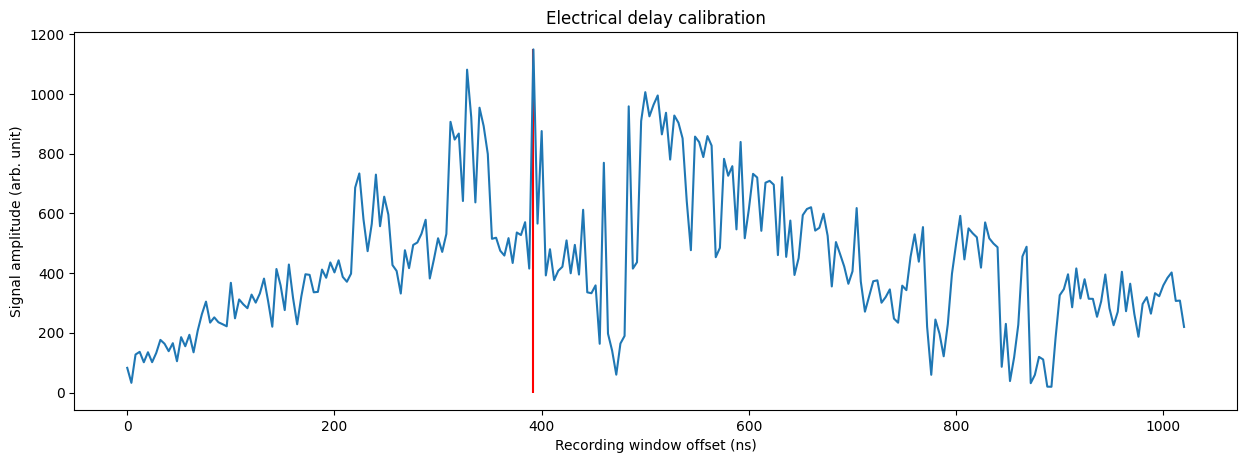

Optimal offset set to 392.0ns


HTML(value="<table style='width:100%'><tr><td> (0/100000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=100000)

Mirror sideband is 11.1 dB suppressed at recording input


HTML(value="<table style='width:100%'><tr><td> (0/100000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=100000)

Value Shift offset set to 5


HTML(value="<table style='width:100%'><tr><td> (0/5000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=5000)

HTML(value="<table style='width:100%'><tr><td> (0/5000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=5000)

Phase was -0.66339 and is now calibrated to 0.07654.


HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

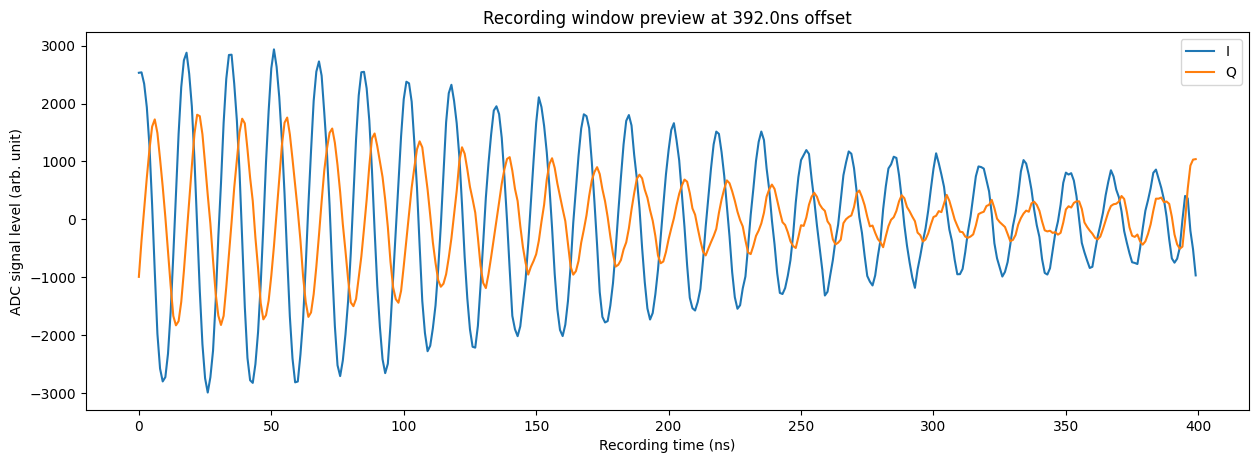

In [17]:
for i in range(len(sample)): 
    ql.init.calibrate_readout(qic, sample, 100000, shift_offset = True, reset_phase = True, cell = i)

## Pseudo-VNA: Find resonator frequency $f_\mathrm{res}$

In [49]:
cid = 0
freq_center = sample[cid]["f_res"]
freq_span = 20e6
freq_step = 0.1e6
averages = 10000

In [83]:
with QiJob() as job: 
    q = QiCells(1)
    ql.jobs.Readout(q[0])
    Wait(q[0], 2e-6)
exp = job.create_experiment(qic, sample, averages = averages, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)

def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.readout.internal_frequency = f - sample[cid]["f_LO (R)"]
    cell.recording.internal_frequency = f - sample[cid]["f_LO (R)"]

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "frequency", 
                   x_set_obj = set_freq, 
                   x_unit = "Hz")

m.dirname = f"Find_f_res_cell{cid}"
m.comment = f'''VNA scan -> resonator freq
 * Cell {cid}
 * averages = {averages}
 * Pulsed Readout Tone
'''
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D()

Find_f_res_cell0 
 VNA scan -> resonator freq
 * Cell 0
 * averages = 10000
 * Pulsed Readout Tone



HTML(value="<table style='width:100%'><tr><td> (0/200) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Find_f_res_cell0', layout=Layout(width='95%'), max=200)

Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZFEVS_Find_f_res_cell0/images


2021-09-14 15:25:41 [WARNING ]: Frequency given in Hz. Conversion to GHz applied. (qfit.py:788)


Latest file: /home/superuser/data/edel_6/Andre_NIST_1Q/QZFEMI_Find_f_res_cell0/QZFEMI_Find_f_res_cell0.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'frequency', 'measurement', 'phase_0', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/frequency', '/entry/data0/phase_0']
assume k = 0.0011
QL = 1.028e+04


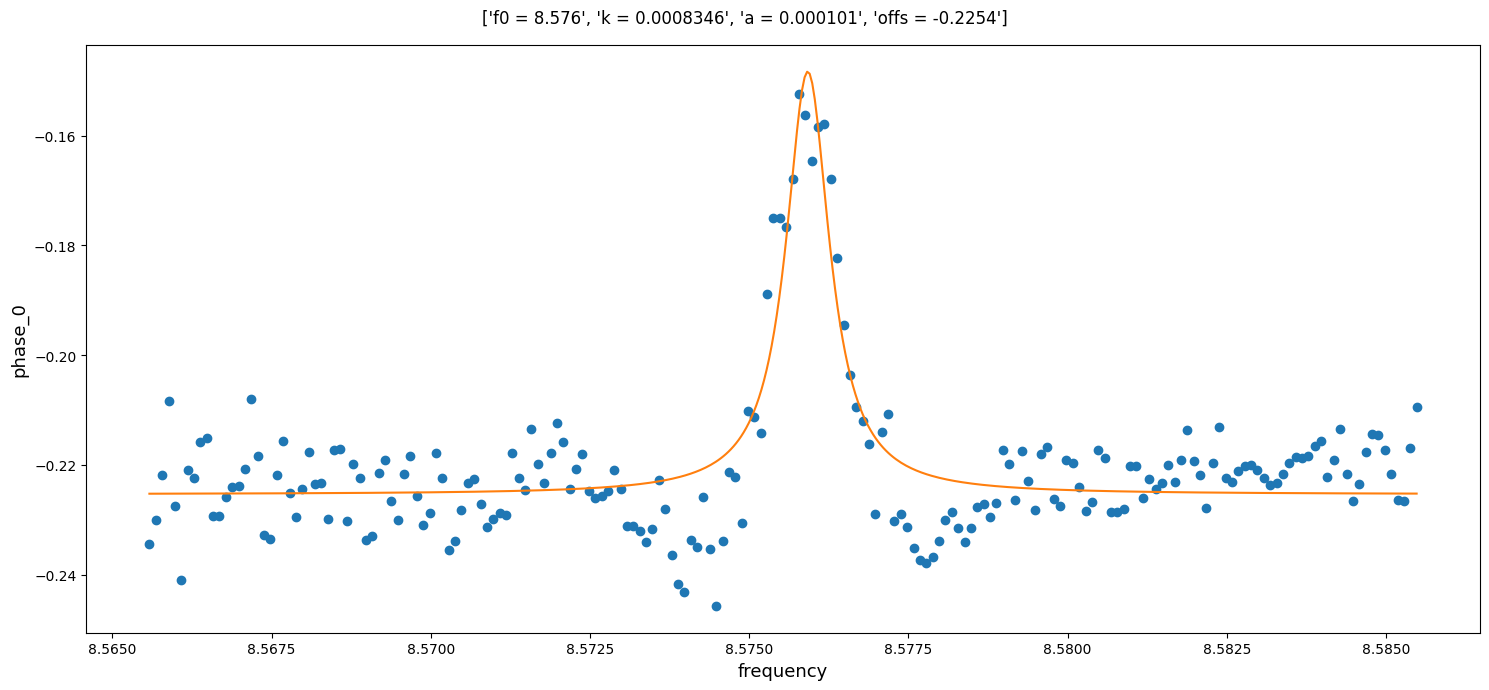

Cell 0: f_resA = 8.575920363734326 GHz (Was: 8.575582 GHz)


Save frequency in sample as f_res and update IF? (y/N)  y


Ok, saving in cell 0!


In [56]:
qf = qfit.QFIT()
qf.load(entries = ['frequency', 'phase_0'])
qf.phase_grad(True)
qf.fit_Lorentzian()
print(f"Cell {cid}: f_resA = {qf.popt[0]} GHz (Was: {sample[cid]['f_res'] * 1e-9: .6f} GHz)")
if input("Save frequency in sample as f_res and update IF? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["f_res"] = qf.popt[0] * 1e9
    sample[cid]["rec_frequency"] = sample[cid]["f_res"] - sample[cid]["f_LO (R)"]

## Two Tone: Find qubit frequency $f_{01}$

In [97]:
cid = 0
freq_center = sample[cid]["f_LO (M)"] - 150e6
freq_span = 500e6
freq_step = 2e6
averages = 20000

In [93]:
frontend_box.set_attenuation_rf_manip(3.0)
frontend_box.get_attenuation_rf_manip()

3.0

In [95]:
cid = 0
freq_center = sample[cid]["f_01"]
freq_span = 10e6
freq_step = 0.1e6
averages = 4000

In [98]:
with QiJob() as excite: 
    q = QiCells(1)
    Play(q[0], QiPulse("cw", frequency = q[0]["manip_frequency"]))
    Wait(q[0], 5 * 10e-6)#q[0]["T1"])
    Play(q[0], QiPulse("off"))
    ql.jobs.Readout(q[0], "result")

exp = excite.create_experiment(qic, sample, averages = averages, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)

def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.manipulation.internal_frequency = f - sample[cid]["f_LO (M)"]

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "drive_frequency", 
                   x_set_obj = set_freq, 
                   x_unit = "Hz")

m.dirname = f"Find_f_01_cell{cid}"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freq
 * Cell {cid}
 * averages = {averages}
 * Pulsed Readout and Manipulation (5 * T1)
'''
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D()

Find_f_01_cell0 
 Pseudo two-tone VNA scan -> qubit transition freq
 * Cell 0
 * averages = 20000
 * Pulsed Readout and Manipulation (5*T1)



HTML(value="<table style='width:100%'><tr><td> (0/250) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Find_f_01_cell0', layout=Layout(width='95%'), max=250)

HTML(value="<table style='width:100%'><tr><td> (0/20000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=20000)

In [91]:
f_new = 6.634e9
print(f"Old: {sample[cid]['f_01'] * 1e-9: .6f} GHz, New: {f_new * 1e-9} GHz")
if input(f"Save in Cell {cid}? [y/N] ") == "y": 
    sample[cid]['f_01'] = f_new
    sample[cid]["manip_frequency"] = f_new - sample[cid]["f_LO (M)"]
    print(sample[cid]["manip_frequency"] * 1e-6, "MHz")

Old: 6.337815 GHz, New: 6.634 GHz


Save in Cell 0? [y/N]  n


2021-09-14 16:26:09 [WARNING ]: Frequency given in Hz. Conversion to GHz applied. (qfit.py:788)


Latest file: /home/superuser/data/edel_6/Andre_NIST_1Q/QZFHAU_TwoTone-Scan_PulsedRO-ChangeLO_cell0/QZFHAU_TwoTone-Scan_PulsedRO-ChangeLO_cell0.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'drive_frequency', 'measurement', 'phase_0', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/drive_frequency', '/entry/data0/phase_0']
assume k = 0.394
QL = 1


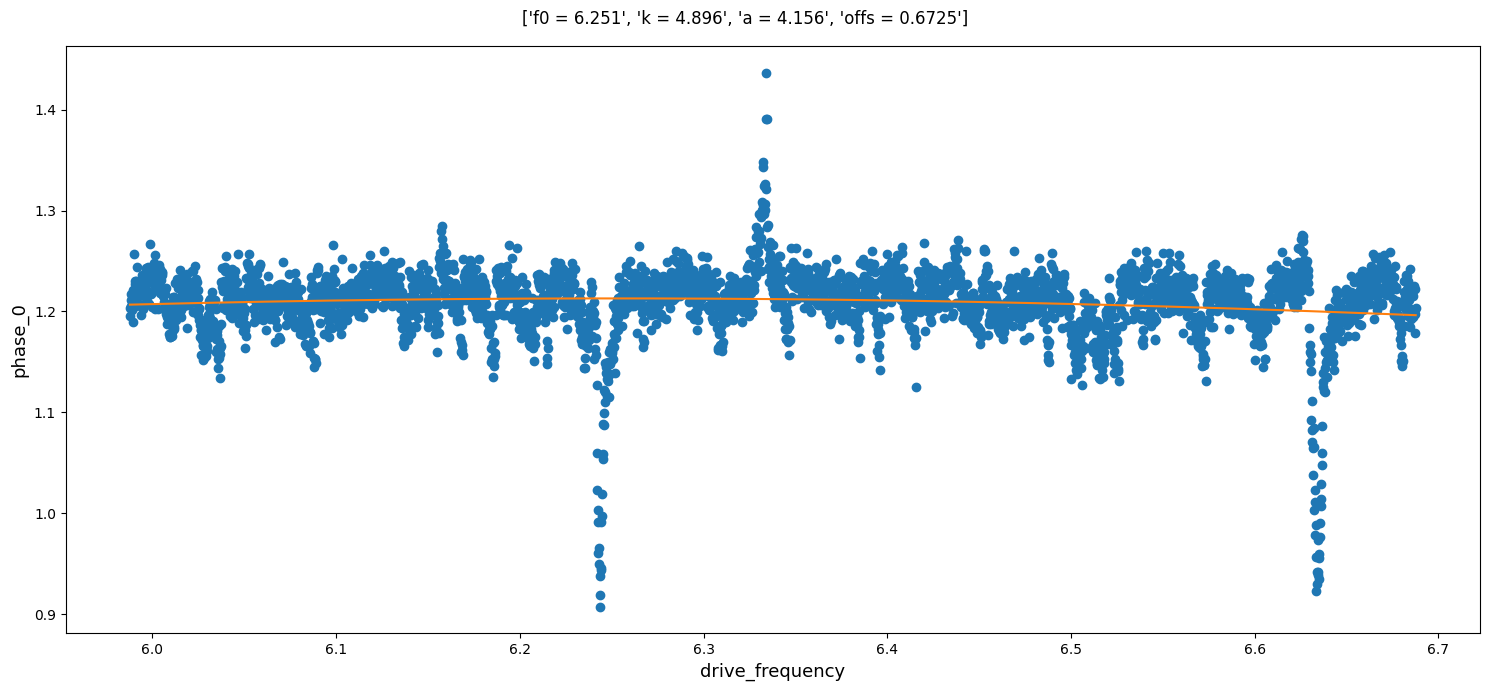

Cell 0: f_01 = 6.251255 GHz (Old value:  6.337815)


Save frequency in sample as f_01 and update IF? y/n n


In [105]:
qf = qfit.QFIT()
#qf.load(entries = ['drive_frequency', 'amplitude_0'])
qf.load(entries = ['drive_frequency', 'phase_0'])
qf.data = np.unwrap(qf.data)
qf.fit_Lorentzian()
print(f"Cell {cid}: f_01 = {qf.popt[0]: .6f} GHz (Old value:  {sample[cid]['f_01'] * 1e-9: .6f})")
if input("Save frequency in sample as f_01 and update IF? y/n") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["f_01"] = qf.popt[0] * 1e9
    sample[cid]["manip_frequency"] = sample[cid]["f_01"] - sample[cid]["f_LO (M)"]

In [102]:
with QiJob() as two_tone: 
    q = QiCells(1)
    Play(q[0], QiPulse("cw", frequency = q[0]["manip_frequency"]))
    Wait(q[0], 5 * q[0]["T1"])
    i = QiVariable(int)
    with ForRange(i, 0, averages): 
        ql.jobs.Readout(q[0])
        Wait(q[0], 2000e-9)
    Play(q[0], QiPulse("off")) # End drive pulse

exp = two_tone.create_experiment(qic, sample, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)

def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.manipulation.internal_frequency = f - sample[cid]["f_LO (M)"]

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "drive_frequency", 
                   x_set_obj = set_freq, 
                   x_unit = "Hz")

m.dirname = f"TwoTone-Scan_PulsedRO_cell{cid}"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freq
 * Cell {cid}
 * averages = {averages}
 * CW Manipulation
 * Pulsed Readout
 * 100ns delay between consecutive readouts (prevent saturation in res)
'''
print(m.dirname, "\n", m.comment)
m.measure_1D()

TwoTone-Scan_PulsedRO_cell0 
 Pseudo two-tone VNA scan -> qubit transition freq
 * Cell 0
 * averages = 10000
 * CW Manipulation
 * Pulsed Readout
 * 100ns delay between consecutive readouts (prevent saturation in res)



HTML(value="<table style='width:100%'><tr><td> (0/3500) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='TwoTone-Scan_PulsedRO_cell0', layout=Layout(width='95%'), max=3500)

Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZFH0C_TwoTone-Scan_PulsedRO_cell0/images


In [104]:
with QiJob() as two_tone: 
    q = QiCells(1)
    Play(q[0], QiPulse("cw", frequency = q[0]["manip_frequency"]))
    Wait(q[0], 5 * q[0]["T1"])
    i = QiVariable(int)
    with ForRange(i, 0, averages): 
        ql.jobs.Readout(q[0])
        Wait(q[0], 2000e-9)
    Play(q[0], QiPulse("off")) # End drive pulse

exp = two_tone.create_experiment(qic, sample, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)

def set_freq(f): 
    mw_src_manip.set_frequency(f - sample[cid]["manip_frequency"])
    #cell = qic.cell[sample[cid].qic_cell]
    #cell.manipulation.internal_frequency = f - sample[cid]["f_LO (M)"]

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "drive_frequency", 
                   x_set_obj = set_freq, 
                   x_unit = "Hz")

m.dirname = f"TwoTone-Scan_PulsedRO-ChangeLO_cell{cid}"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freq
 * Cell {cid}
 * averages = {averages}
 * CW Manipulation
 * Pulsed Readout
 * 100ns delay between consecutive readouts (prevent saturation in res)
 * Changing LO frequency
'''
print(m.dirname, "\n", m.comment)
m.measure_1D()

TwoTone-Scan_PulsedRO-ChangeLO_cell0 
 Pseudo two-tone VNA scan -> qubit transition freq
 * Cell 0
 * averages = 10000
 * CW Manipulation
 * Pulsed Readout
 * 100ns delay between consecutive readouts (prevent saturation in res)
 * Changing LO frequency



HTML(value="<table style='width:100%'><tr><td> (0/3500) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='TwoTone-Scan_PulsedRO-ChangeLO_cell0', layout=Layout(width='95%'), max=3500)

Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZFHAU_TwoTone-Scan_PulsedRO-ChangeLO_cell0/images


In [79]:
mw_src_manip.set_frequency(sample[cid]["f_LO (M)"])

with QiJob() as two_tone: 
    q = QiCells(1)
    Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"], hold = True))
    #PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"], hold = True))
    Wait(q[0], 5 * q[0]["T1"])
    i = QiVariable(int)
    with ForRange(i, 0, averages): 
        ql.jobs.Readout(q[0])
        #Recording(q[0], q[0]["rec_length"], q[0]["rec_offset"])
        Wait(q[0], 100e-9)
    Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"])) # End drive pulse
    #PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"])) # End rec pulse

exp = two_tone.create_experiment(qic, sample, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)

def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.manipulation.internal_frequency = f - sample[cid]["f_LO (M)"]

m.set_y_parameters(y_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   y_coordname = "drive_frequency", 
                   y_set_obj = set_freq, 
                   y_unit = "Hz")

def set_att(a): 
    frontend_box.set_attenuation_rf_readout(a)

m.set_x_parameters(x_vec = np.arange(0, 30, 3), 
                   x_coordname = "readout_attenuation", 
                   x_set_obj = set_att, 
                   x_unit = "dB")

m.dirname = f"TwoTone-ScanReadoutAtten_PulsedRO_cell{cid}"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freq
 * Cell {cid}
 * averages = {averages}
 * CW Manipulation
 * Pulsed Readout
 * 100ns delay between consecutive readouts (prevent saturation in res)
'''
print(m.dirname, "\n", m.comment)
fbp = {p: frontend_box.get(p) for p in frontend_box.get_parameter_names()}
m.comment +=  f"\n\n{sample}\n\nFrontend Box Params: \n{fbp}"

old_manip_atten = frontend_box.get_attenuation_rf_manip()
old_readout_atten = frontend_box.get_attenuation_rf_readout()
try: 
    # Reduce power for CW
    #frontend_box.set_attenuation_rf_manip(9)
    #frontend_box.set_attenuation_rf_readout(15)
    
    m.measure_2D()
finally: 
    pass
    #frontend_box.set_attenuation_rf_manip(old_manip_atten)
    #frontend_box.set_attenuation_rf_readout(old_readout_atten)

TwoTone-ScanReadoutAtten_PulsedRO_cell0 
 Pseudo two-tone VNA scan -> qubit transition freq
 * Cell 0
 * averages = 10000
 * CW Manipulation
 * Pulsed Readout
 * 100ns delay between consecutive readouts (prevent saturation in res)



HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='TwoTone-ScanReadoutAtten_PulsedRO_cell0', layout=Layout(width='95%'), max=10…

Plots saved in /home/superuser/data/perl_4/Richard_2/QZ3Y0M_TwoTone-ScanReadoutAtten_PulsedRO_cell0/images


In [268]:
freq_center = sample[cid]["f_LO (M)"] - 150e6
freq_span = 500e6
freq_step = 2e6
averages = 20000

rfreq_center = 6.98e9
rfreq_span = 250e6
rfreq_step = 0.5e6

In [276]:
rfreqs = np.concatenate([np.arange(-8e6, 8e6, 0.4e6) + f for f in qubits_fres])

In [277]:
mw_src_manip.set_frequency(sample[cid]["f_LO (M)"])
cid = 0

with QiJob() as two_tone: 
    q = QiCells(1)
    Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"], hold = True))
    PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"], hold = True))
    Wait(q[0], 5 * q[0]["T1"])
    i = QiVariable(int)
    with ForRange(i, 0, averages): 
        Recording(q[0], q[0]["rec_length"], q[0]["rec_offset"])
        Wait(q[0], 100e-9)
    Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"])) # End drive pulse
    PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"])) # End rec pulse

exp = two_tone.create_experiment(qic, sample, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)

def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.manipulation.internal_frequency = f - sample[cid]["f_LO (M)"]

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "drive_frequency", 
                   x_set_obj = set_freq, 
                   x_unit = "Hz")

def set_rfreq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.readout.internal_frequency = f - sample[cid]["f_LO (R)"]
    cell.recording.internal_frequency = f - sample[cid]["f_LO (R)"]

m.set_y_parameters(y_vec = rfreqs, #rfreq_center + np.arange(-rfreq_span / 2, rfreq_span / 2, rfreq_step), 
                   y_coordname = "readout_frequency", 
                   y_set_obj = set_rfreq, 
                   y_unit = "Hz")

m.dirname = f"TwoToneFrequencyScan_cell{cid}"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freqs
 * Using Cell {cid}
 * averages = {averages}
 * CW Readout and Manipulation
'''
print(m.dirname, "\n", m.comment)
fbp = {p: frontend_box.get(p) for p in frontend_box.get_parameter_names()}
m.comment +=  f"\n\n{sample}\n\nFrontend Box Params: \n{fbp}"

old_manip_atten = frontend_box.get_attenuation_rf_manip()
old_readout_atten = frontend_box.get_attenuation_rf_readout()
try: 
    # Reduce power for CW
    frontend_box.set_attenuation_rf_manip(15)
    frontend_box.set_attenuation_rf_readout(18)
    
    m.measure_2D()
finally: 
    frontend_box.set_attenuation_rf_manip(old_manip_atten)
    frontend_box.set_attenuation_rf_readout(old_readout_atten)

TwoToneFrequencyScan_cell0 
 Pseudo two-tone VNA scan -> qubit transition freqs
 * Using Cell 0
 * averages = 20000
 * CW Readout and Manipulation



HTML(value="<table style='width:100%'><tr><td> (0/50000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='TwoToneFrequencyScan_cell0', layout=Layout(width='95%'), max=50000)

Plots saved in /home/superuser/data/perl_4/Richard/QT273M_TwoToneFrequencyScan_cell0/images


## Recalibrate fres

In [109]:
cid = 1
freq_center = sample[cid]["f_res"]
freq_span = 10e6
freq_step = 50e3
averages = 10000

In [268]:
mw_src_manip.set_frequency(sample[cid]["f_LO (M)"])
mw_src_readout.set_frequency(sample[cid]["f_LO (R)"])

with QiJob() as two_tone: 
    tone = QiVariable(int, name = "tone")
    q = QiCells(1)
    with If(tone == 1): 
        Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"], hold = True))
    PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"], hold = True))
    Wait(q[0], 5 * q[0]["T1"])
    i = QiVariable(int)
    with ForRange(i, 0, averages): 
        Recording(q[0], q[0]["rec_length"], q[0]["rec_offset"])
    Play(q[0], QiPulse(4e-9, frequency = q[0]["manip_frequency"])) # End drive pulse
    PlayReadout(q[0], QiPulse(4e-9, frequency = q[0]["rec_frequency"])) # End rec pulse

exp = two_tone.create_experiment(qic, sample, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)
exp.init_variable("tone", 1)

def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.readout.internal_frequency = f - sample[cid]["f_LO (R)"]
    cell.recording.internal_frequency = f - sample[cid]["f_LO (R)"]

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "readout_frequency", 
                   x_set_obj = set_freq, 
                   x_unit = "Hz")

m.dirname = f"Recalibrate_f_res_cell{cid}"
m.comment = f'''Pseudo two-tone VNA scan -> f_res readout freq
 * Cell {cid}
 * averages = {averages}
 * CW Readout without Manipulation
'''
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

old_manip_atten = frontend_box.get_attenuation_rf_manip()
old_readout_atten = frontend_box.get_attenuation_rf_readout()
try: 
    # Reduce power for CW
    frontend_box.set_attenuation_rf_manip(24)
    frontend_box.set_attenuation_rf_readout(18)
    
    m.measure_1D()
finally: 
    frontend_box.set_attenuation_rf_manip(old_manip_atten)
    frontend_box.set_attenuation_rf_readout(old_readout_atten)

Recalibrate_f_res_cell4 
 Pseudo two-tone VNA scan -> f_res readout freq
 * Cell 4
 * averages = 10000
 * CW Readout without Manipulation



HTML(value="<table style='width:100%'><tr><td> (0/200) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Recalibrate_f_res_cell4', layout=Layout(width='95%'), max=200)

Plots saved in /home/superuser/data/perl_4/Richard_2/QTRJRD_Recalibrate_f_res_cell4/images


2021-05-27 13:27:50 [WARNING ]: Frequency given in Hz. Conversion to GHz applied. (qfit.py:788)


Latest file: /home/superuser/data/perl_4/Richard_2/QTRJRD_Recalibrate_f_res_cell4/QTRJRD_Recalibrate_f_res_cell4.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'measurement', 'phase_0', 'readout_frequency', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/readout_frequency', '/entry/data0/phase_0']
assume k = 0.00015
QL = 4.807e+04


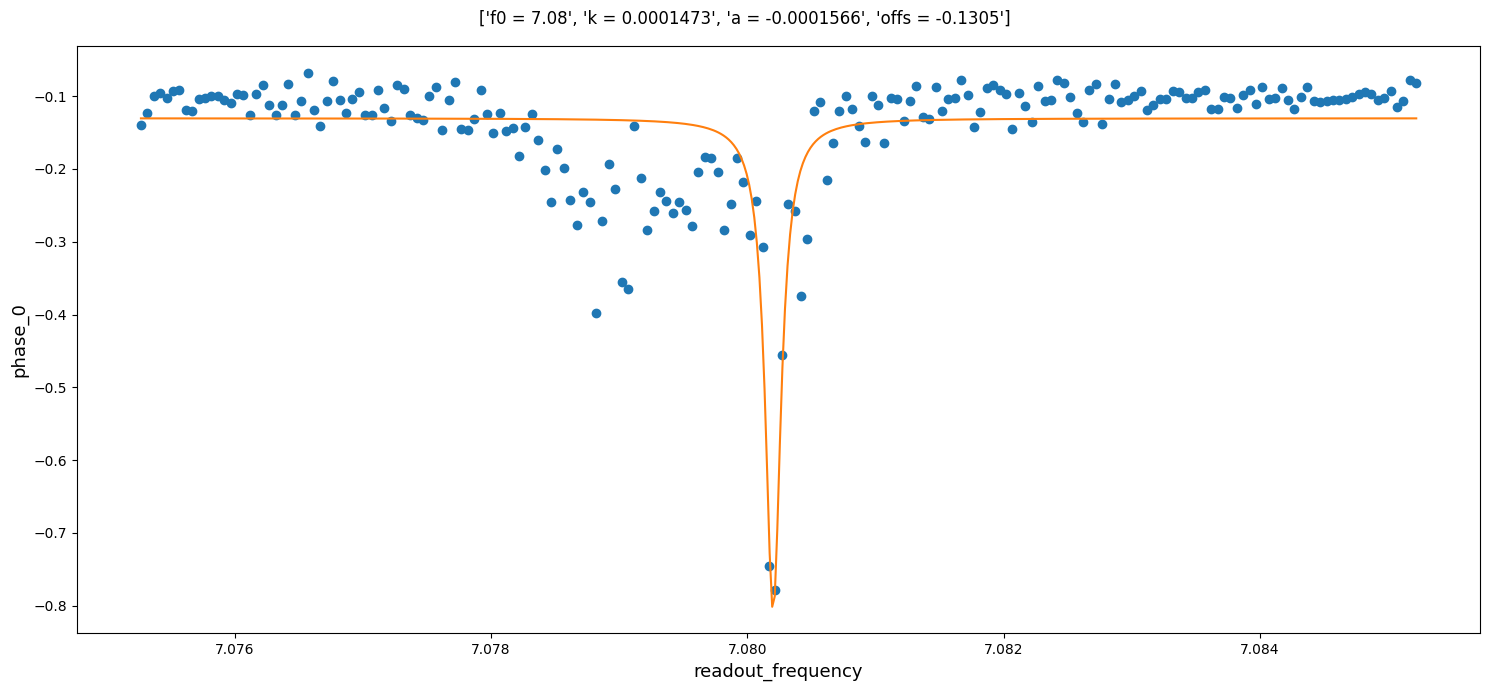

Cell 4: f_resA = 7.080201172598035 GHz (Was: 7.080269 GHz)


Save frequency in sample as f_res and update IF? (y/N)  y


Ok, saving in cell 4!


In [269]:
qf = qfit.QFIT()
qf.load(entries = ['readout_frequency', 'phase_0'])
qf.phase_grad(True)
qf.fit_Lorentzian()
print(f"Cell {cid}: f_resA = {qf.popt[0]} GHz (Was: {sample[cid]['f_res'] * 1e-9: .6f} GHz)")
if input("Save frequency in sample as f_res and update IF? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["f_res"] = qf.popt[0] * 1e9
    sample[cid]["rec_frequency"] = sample[cid]["f_res"] - sample[cid]["f_LO (R)"]

# Single-Qubit Characterizations

## Rabi

In [230]:
frontend_box.set_attenuation_rf_manip(2)
frontend_box.get_attenuation_rf_readout()

In [231]:
t_max = 1000e-9
t_step = 32e-9#8e-9
averages = 1000
iterations = 10
cid = 0

In [232]:
exp = ql.jobs.Rabi(0, t_max, t_step).create_experiment(qic, sample, cell_map = [cid], averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'pulse_length', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"Rabi_cell{cid}"
m.comment = f"""Single Cell Rabi Experiment -> pi pulse time
 * {iterations} iterations a {averages} averages
 * Cell {cid}
 * Frontend RF Manipulation Attenuation {frontend_box.get_attenuation_rf_manip()} dB
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D_AWG(iterations = iterations)

Rabi_cell0 
 Single Cell Rabi Experiment -> pi pulse time
 * 10 iterations a 1000 averages
 * Cell 0
 * Frontend RF Manipulation Attenuation 2.0 dB



HTML(value="<table style='width:100%'><tr><td> (0/10) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='Rabi_cell0', layout=Layout(width='95%'), max=10)

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

HTML(value="<table style='width:100%'><tr><td> (0/32) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=32)

Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZGS7D_Rabi_cell0/images


In [236]:
sample[cid]["pi"] = 38e-9

Latest file: /home/superuser/data/edel_6/Andre_NIST_1Q/QZGS7D_Rabi_cell0/QZGS7D_Rabi_cell0.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_avg_0', 'iteration', 'measurement', 'phase_0', 'phase_avg_0', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_0']


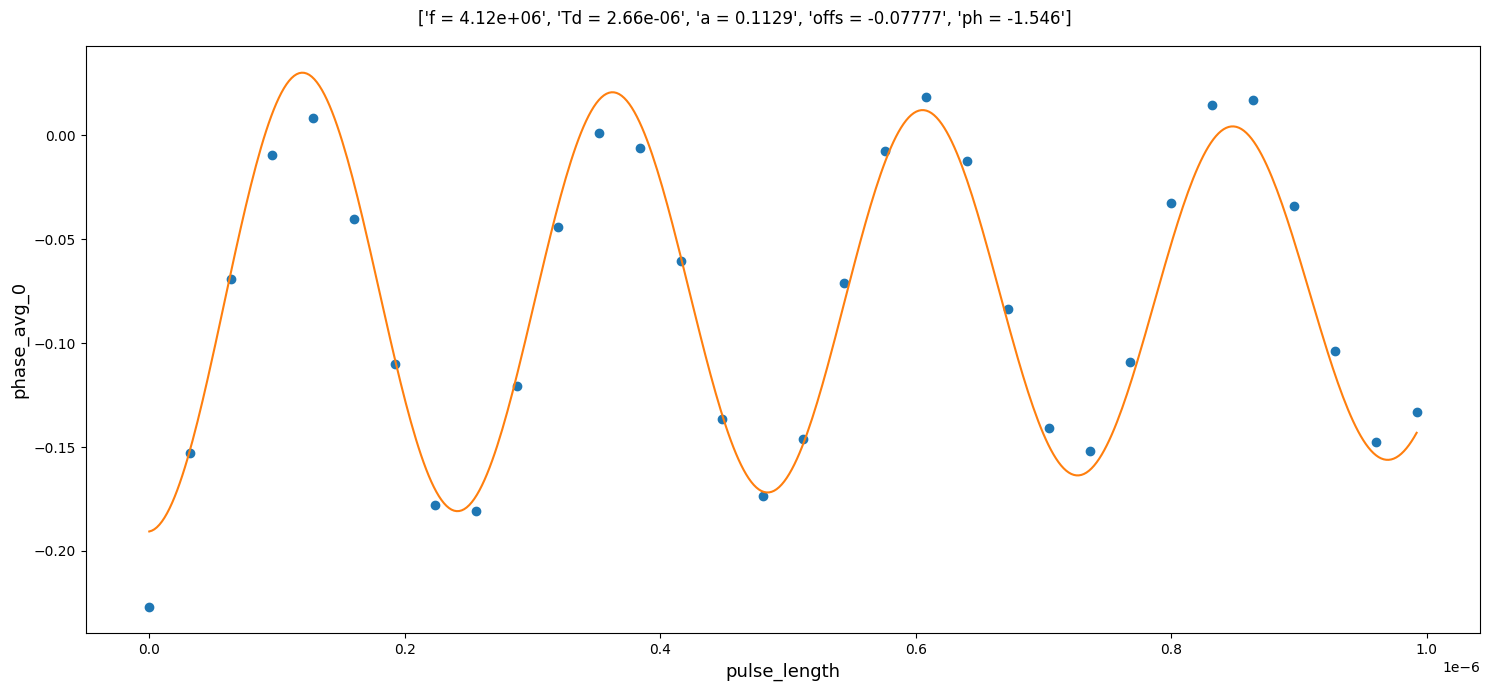

Cell 0: t_pi = 121.36 ns


Save pi pulse time in sample as pi? y/n y


Ok, saving in cell 0!


In [233]:
qf = qfit.QFIT()
qf.load(entries = ['pulse_length', f'phase_avg_0'])
qf.fit_damped_sine()
t_pi = 0.5 / qf.popt[0]
print(f"Cell {cid}: t_pi = {t_pi * 1e9: .2f} ns")
if input("Save pi pulse time in sample as pi? y/n") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["pi"] = t_pi

## Rabi with Detuning Sweep

In [149]:
cid = 0
t_max = 1200e-9
t_step = 8e-9
averages = 800

detuning_max = 700e6
detuning_step = 0.5e6
frequencies = sample[cid]["f_LO (M)"] + qkit.range(-detuning_max, detuning_max, detuning_step)

In [156]:
frontend_box.set_attenuation_rf_manip(0)
frontend_box.set_attenuation_rf_readout(3)

True

In [157]:
qic.cell[0].recording.value_shift_offset #-=  1

4

In [158]:
exp = ql.jobs.Rabi(0, t_max, t_step).create_experiment(qic, sample, averages = averages, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'pulse_length', 
                   x_set_obj = None, 
                   x_unit = 's')
            
def set_detuning(detuning): 
    cell = sample[cid]
    qic_cell = qic.cell[cell.qic_cell]
    f_IF = cell["manip_frequency"] + detuning
    qic_cell.manipulation.internal_frequency = f_IF
    
def set_freq(f): 
    cell = qic.cell[sample[cid].qic_cell]
    cell.manipulation.internal_frequency = f - sample[cid]["f_LO (M)"]

m.set_y_parameters(y_vec = frequencies, 
                   y_coordname = 'manipulation_frequency', 
                   y_set_obj = set_freq, 
                   y_unit = 'Hz')

m.dirname = f"RabiWithDetuning_cell{cid}"
m.comment = f"""Single Cell Rabi Experiment with detuning
 * Cell {cid}
 * {averages} averages
 12dB instead of 6dB readout attenuation
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_2D_AWG()

RabiWithDetuning_cell0 
 Single Cell Rabi Experiment with detuning
 * Cell 0
 * 500 averages
 12dB instead of 6dB readout attenuation



HTML(value="<table style='width:100%'><tr><td> (0/41) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='RabiWithDetuning_cell0', layout=Layout(width='95%'), max=41)

HTML(value="<table style='width:100%'><tr><td> (0/500) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=500)

HTML(value="<table style='width:100%'><tr><td> (0/50) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=50)

Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZGPE8_RabiWithDetuning_cell0/images


In [163]:
sample[cid]["f_LO (M)"] = 6.5e9

In [165]:
sample[cid]["f_01"] = 6.3265e9
sample[cid]["manip_frequency"] = sample[cid]["f_01"] - sample[cid]["f_LO (M)"]
mw_src_manip.set_frequency(sample[0]["f_LO (M)"])
print(sample[cid]["f_01"] / 1e9,  sample[cid]["manip_frequency"] / 1e6, sample[cid]["f_LO (M)"] / 1e9)

6.3265 -173.5 6.5


In [ ]:
exp = ql.jobs.Rabi(0, t_max, t_step).create_experiment(qic, sample, averages = averages, cell_map = [cid])
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'pulse_length', 
                   x_set_obj = None, 
                   x_unit = 's')
            
def set_f01(f01): 
    cell = sample[cid]
    f_IF = cell["manip_frequency"]
    mw_src_manip.set_frequency(f01 - f_IF)
m.set_y_parameters(y_vec = sample[cid]["f_01"] + np.arange(-detuning_max, detuning_max, detuning_step), 
                   y_coordname = 'frequency', 
                   y_set_obj = set_f01, 
                   y_unit = 'Hz')

m.dirname = f"RabiWithDetuning-SweepLO_cell{cid}"
m.comment = f"""Single Cell Rabi Experiment with detuning
 * Cell {cid}
 * {averages} averages
 * Sweeping LO instead of IF (fixed IF at {sample[cid]["manip_frequency"] * 1e-6: .3f} MHz)
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_2D_AWG()

In [227]:
#sample[cid]["manip_frequency"] -=  186e6
sample[cid]["f_01"] = 6.334e9 # manip_flo + sample[cid]["manip_frequency"]

In [228]:
sample[cid]["f_01"], sample[cid]["manip_frequency"]

(6334000000.0, 80000000.0)

In [229]:
sample[0]["f_LO (M)"] = sample[0]["f_01"] - sample[0]["manip_frequency"]
mw_src_manip.set_frequency(sample[0]["f_LO (M)"])

True

## T1

In [238]:
t_max = 100e-6 #8e-6
t_step = 2e-6 #200e-9
averages = 1000
iterations = 10
cid = 0

In [239]:
exp = ql.jobs.T1(0, t_max, t_step).create_experiment(qic, sample, cell_map = [cid], averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'delay', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"T1_cell{cid}"
m.comment = f"""Single Cell T1 Experiment -> decay time
 * {iterations} iterations a {averages} averages
 * Cell {cid}
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D_AWG(iterations = iterations)

T1_cell0 
 Single Cell T1 Experiment -> decay time
 * 10 iterations a 1000 averages
 * Cell 0



HTML(value="<table style='width:100%'><tr><td> (0/10) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='T1_cell0', layout=Layout(width='95%'), max=10)

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

HTML(value="<table style='width:100%'><tr><td> (0/50) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=50)

Latest file: /home/superuser/data/edel_6/Andre_NIST_1Q/QZGSAP_T1_cell0/QZGSAP_T1_cell0.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_avg_0', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_avg_0', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_0']


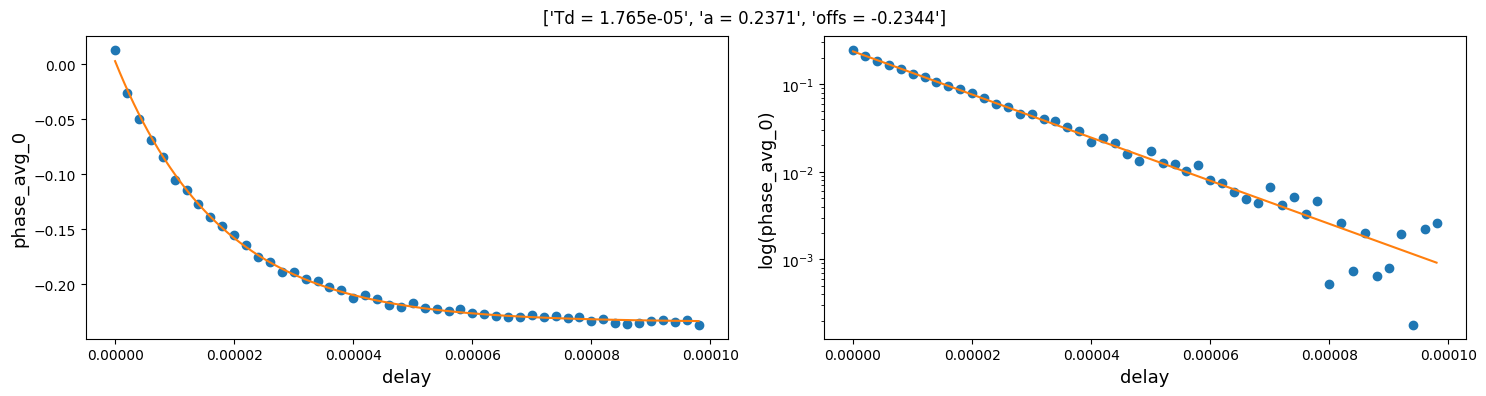

Cell 0: T1 = 17.648 µs (Old: 14.61 µs)
Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZGSAP_T1_cell0/images


Save T1 time in sample? (y/N)  y


Ok, saving in cell 0!


In [240]:
qf = qfit.QFIT()
qf.load(entries = ['delay', f'phase_avg_0'])
qf.fit_exp()
t1 = qf.popt[0]
print(f"Cell {cid}: T1 = {t1 * 1e6: .3f} µs (Old: {sample[cid]['T1'] * 1e6: .2f} µs)")
if input(f"Save T1 time in sample? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["T1"] = t1

## SpinEcho

In [246]:
t_max = 100e-6
t_step = 2e-6
averages = 1000
iterations = 10
cid = 0

In [ ]:
exp = ql.jobs.SpinEcho(0, t_max, t_step).create_experiment(qic, sample, cell_map = [cid], averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'delay', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"SpinEcho_cell{cid}"
m.comment = f"""Single Cell SpinEcho Experiment -> decoherence time
 * {iterations} iterations a {averages} averages
 * Cell {cid}
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D_AWG(iterations = iterations)

Latest file: /home/superuser/data/edel_6/Richard_1Q/QZ7M6N_SpinEcho_cell0/QZ7M6N_SpinEcho_cell0.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_avg_0', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_avg_0', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_0']


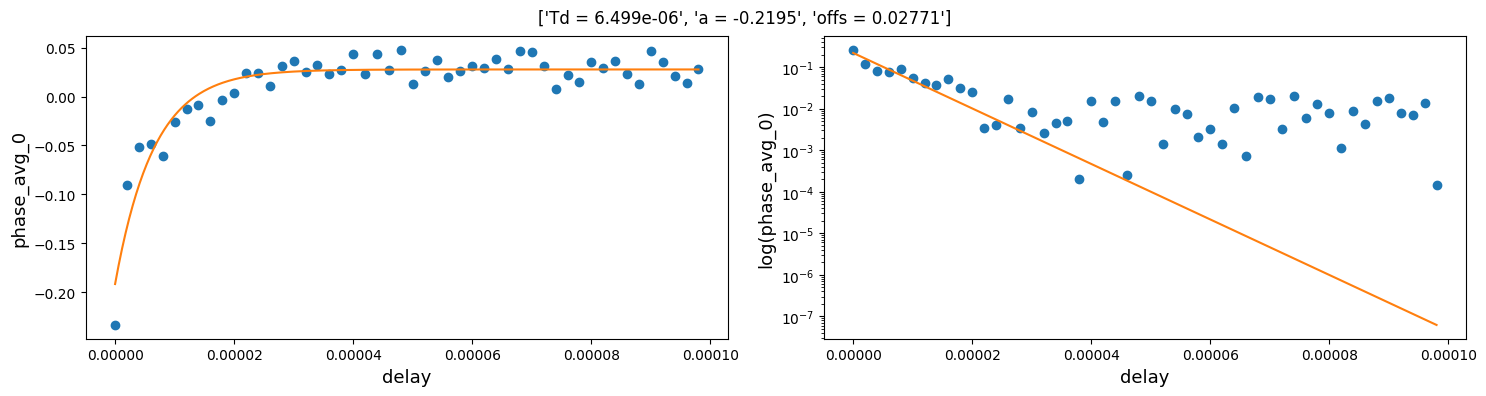

Cell 0: T2* = 6.499 µs (Old: 0.00 µs)


Save T2* time in sample? (y/N)  y


Ok, saving in cell 0!


In [248]:
qf = qfit.QFIT()
qf.load(entries = ['delay', f'phase_avg_0'])
qf.fit_exp()
t1 = qf.popt[0]
print(f"Cell {cid}: T2 * = {t1 * 1e6: .3f} µs (Old: {(sample[cid]['T2 * '] or 0) * 1e6: .2f} µs)")
if input(f"Save T2 * time in sample? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["T2 * "] = t1

## Ramsey

In [235]:
t_max = 10e-6
t_step = 80e-9
detuning = 1e6
averages = 1000
iterations = 5
cid = 0
print(f"This will give {t_max * detuning: .2f} oscillations, each sampled with {1 / t_step / detuning: .1f} points")

This will give 10.00 oscillations, each sampled with 12.5 points


In [236]:
job = ql.jobs.Ramsey(0, t_max, t_step, detuning)
exp = job.create_experiment(qic, sample, cell_map = [cid], averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'delay', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"Ramsey_cell{cid}"
m.comment = f"""Single Cell Ramsey Experiment -> decoherence time + detuning
 * {iterations} iterations a {averages} averages
 * Cell {cid}
 * Detuning {detuning * 1e-6: .3f} MHz
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D_AWG(iterations = iterations)

Ramsey_cell0 
 Single Cell Ramsey Experiment -> decoherence time + detuning
 * 5 iterations a 1000 averages
 * Cell 0
 * Detuning 1.000 MHz



HTML(value="<table style='width:100%'><tr><td> (0/5) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Ramsey_cell0', layout=Layout(width='95%'), max=5)

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

HTML(value="<table style='width:100%'><tr><td> (0/125) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=125)

Latest file: /home/superuser/data/edel_6/Andre_NIST_1Q/QZGS8S_Ramsey_cell0/QZGS8S_Ramsey_cell0.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_avg_0', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_avg_0', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_0']


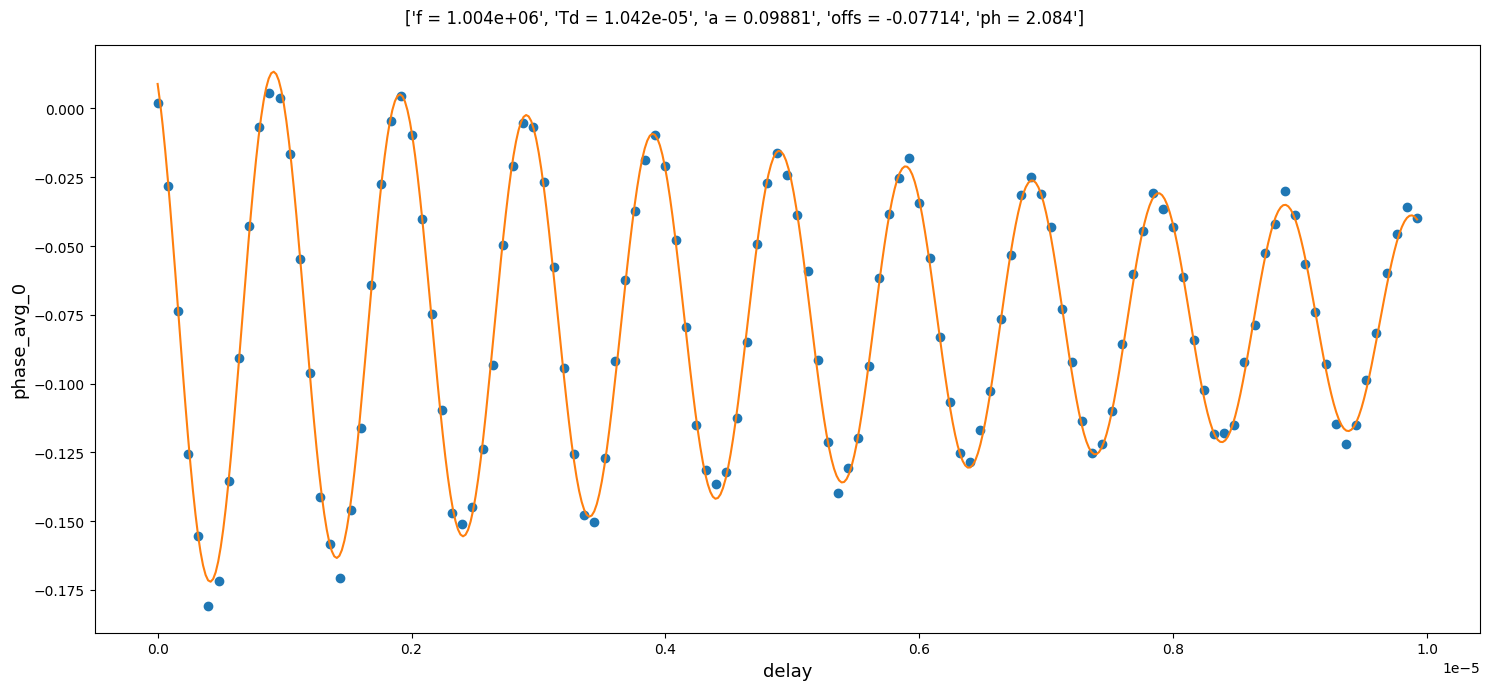

Cell 0: T2 = 10.419 µs (Old: 9.022 µs)
Plots saved in /home/superuser/data/edel_6/Andre_NIST_1Q/QZGS8S_Ramsey_cell0/images


Save T2 time in sample? (y/N)  y


Ok, saving in cell 0!
Cell 0: f_01 = 6334.183 MHz (Old: 6334.187 MHz)


Save f_01 and update manip_frequency in sample? (y/N)  y


Ok, saving in cell 0!


In [237]:
cell = sample[cid]
qf = qfit.QFIT()
qf.load(entries = ['delay', f'phase_avg_0'])
qf.fit_damped_sine([
    np.abs(detuning), 
    cell['T2'] or 1e-6, 
    (np.max(qf.data) - np.min(qf.data)) / 2, 
    np.mean(qf.data), 
    np.pi #if qf.data[0] < np.mean(qf.data) else 0
])
f01 = cell["f_01"] + detuning + qf.popt[0] * (1 if detuning < 0 else -1)
t2 = qf.popt[1]
print(f"Cell {cid}: T2 = {t2 * 1e6: .3f} µs (Old: {(cell['T2'] or 0) * 1e6: .3f} µs)")
if input(f"Save T2 time in sample? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    cell["T2"] = t2
print(f"Cell {cid}: f_01 = {f01 * 1e-6: .3f} MHz (Old: {cell['f_01'] * 1e-6: .3f} MHz)")
if input(f"Save f_01 and update manip_frequency in sample? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    cell["f_01"] = f01
    cell["manip_frequency"] = cell["f_01"] - cell["f_LO (M)"]

# Multi-Qubit Characterizations

## Multi-tone amplitude calibration
The amplitude of individual pulses needs to be reduced in order to be able to perform simultaneous pulses for all qubits

In [136]:
twpa.off()

In [37]:
 # 5 Cells: 0.28, 4 Cells: 0.35 (can also be slightly frequency depending)
amp_r = 0.28
amp_m = 0.28
for cell in qic.cell: 
    cell.readout.amplitude_calibration = (amp_r, amp_r)
    #cell.manipulation.amplitude_calibration = (amp_m, amp_m)

with QiJob() as amplitude_test: 
    for cell in QiCells(len(sample)): 
        # Turn on the output pulses
        Play(cell, QiPulse(4e-9, frequency = cell["manip_frequency"], hold = True))
        PlayReadout(cell, QiPulse(4e-9, frequency = cell["rec_frequency"], hold = True))
        # Wait long time so a lot of different phase constellations occur
        Wait(cell, 0.1)
        # Turn off the pulses again
        Play(cell, QiPulse(4e-9, frequency = cell["manip_frequency"]))
        PlayReadout(cell, QiPulse(4e-9, frequency = cell["rec_frequency"]))
amplitude_test.run(qic, sample)
# DAC1 + 2: Manipulation, DAC3 + 4: Readout

Also optimize input signal level by using value_shift_offset: 

In [25]:
for cell in qic.cell: 
    cell.recording.recording_duration = 400e-9
    cell.recording.value_shift_offset = 4#6

In [44]:
with QiJob() as multi_readout: 
    for cell in QiCells(len(sample)): 
        # Perform recording to check returned amplitude
        ql.jobs.Readout(cell, save_to = "result")
multi_readout.run(qic, sample, averages = 10000)

HTML(value="<table style='width:100%'><tr><td> (0/10000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=10000)

In [47]:
for cid, (job_cell, cell) in enumerate(zip(multi_readout.cells, sample)): 
    data = job_cell.data("result")
    data_complex = data[0][0] + 1j * data[1][0]
    data_amp = np.abs(data_complex)
    old_shift_offset = qic.cell[cell.qic_cell].recording.value_shift_offset
    shift_offset = old_shift_offset + int(np.floor(15 + np.log2(0.2) - np.log2(data_amp)))
    if shift_offset < 0: 
        shift_offset = 0
    if shift_offset > 8: 
        shift_offset = 8
    print(f"Cell {cid}: value shift offset = {shift_offset} (Was: {old_shift_offset}; Amplitude will change from {int(data_amp)} to ~{int(data_amp) * 2 ** (shift_offset - old_shift_offset)})")
    if input("Update new offset in recording module? y/n") == "y": 
        print(f"Ok, updating in cell {cid}!")
        qic.cell[cell.qic_cell].recording.value_shift_offset = shift_offset 

Cell 0: value shift offset = 6 (Was: 7; Amplitude will change from 7268 to  ~3634.0)


Update new offset in recording module? y/n y


Ok, updating in cell 0!
Cell 1: value shift offset = 7 (Was: 8; Amplitude will change from 7367 to  ~3683.5)


Update new offset in recording module? y/n y


Ok, updating in cell 1!
Cell 2: value shift offset = 8 (Was: 8; Amplitude will change from 4987 to  ~4987)


Update new offset in recording module? y/n y


Ok, updating in cell 2!
Cell 3: value shift offset = 8 (Was: 8; Amplitude will change from 4945 to  ~4945)


Update new offset in recording module? y/n y


Ok, updating in cell 3!
Cell 4: value shift offset = 8 (Was: 8; Amplitude will change from 4114 to  ~4114)


Update new offset in recording module? y/n y


Ok, updating in cell 4!


## Two Tone: Find qubit frequency $f_{01}$

In [367]:
freq_center = manip_flo - 100e6
freq_span = 600e6
freq_step = 1e6
averages = 20000

In [369]:
mw_src_manip.set_frequency(manip_flo)

with QiJob() as two_tone: 
    for q in QiCells(len(sample)): 
        Play(q, QiPulse(4e-9, hold = True))
        PlayReadout(q, QiPulse(4e-9, frequency = q["rec_frequency"], hold = True))
        Wait(q, 5 * q["T1"])
        i = QiVariable(int)
        with ForRange(i, 0, averages): 
            Recording(q, q["rec_length"], q["rec_offset"])
        Play(q, QiPulse(4e-9)) # End drive pulse
        PlayReadout(q, QiPulse(4e-9, frequency = q["rec_frequency"])) # End rec pulse

exp = two_tone.create_experiment(qic, sample)
m = Measure_td(qic.sample, exp.readout)

def set_frequency(f): 
    for c in sample: 
        cell = qic.cell[c.qic_cell]
        cell.manipulation.internal_frequency = f - manip_flo

m.set_x_parameters(x_vec = freq_center + np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "drive_frequency", 
                   x_set_obj = set_frequency, 
                   x_unit = "Hz")

m.dirname = f"MultiTwoTone"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freq
 * All cells parallel
 * averages = {averages}
 * CW Readout and Manipulation
'''
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

old_manip_atten = frontend_box.get_attenuation_rf_manip()
old_readout_atten = frontend_box.get_attenuation_rf_readout()
try: 
    # Reduce power for CW
    frontend_box.set_attenuation_rf_manip(24)
    frontend_box.set_attenuation_rf_readout(18 + 12)
    
    m.measure_1D()
finally: 
    frontend_box.set_attenuation_rf_manip(old_manip_atten)
    frontend_box.set_attenuation_rf_readout(old_readout_atten)

/home/superuser/qup_client/qiclib/code/qi_jobs.py:252: UserWarning: Manipulation pulses without frequency given, using 90 MHz.
  warnings.warn(


MultiTwoTone 
 Pseudo two-tone VNA scan -> qubit transition freq
 * All cells parallel
 * averages = 20000
 * CW Readout and Manipulation



HTML(value="<table style='width:100%'><tr><td> (0/600) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='MultiTwoTone', layout=Layout(width='95%'), max=600)

Plots saved in /home/superuser/data/perl_4/Richard_2/QU0GWD_MultiTwoTone/images


In [381]:
cid = 4
f_new = 4.9045e9
print(f"Old: {sample[cid]['f_01'] * 1e-9: .6f} GHz, New: {f_new * 1e-9} GHz")
if input(f"Save in Cell {cid}? [y/N] ") == "y": 
    sample[cid]['f_01'] = f_new
    sample[cid]["manip_frequency"] = f_new - sample[cid]["f_LO (M)"]

Old: 4.901030 GHz, New: 4.9045000000000005 GHz


Save in Cell 4? [y/N]  y


In [259]:
cid = 2
print(sample[cid]["f_01"] * 1e-9, sample[cid]["manip_frequency"] * 1e-6)

4.67765360616487 -292.3463938351307


In [54]:
freq_span = 100e6
freq_step = 0.1e6
averages = 10000

In [55]:
mw_src_manip.set_frequency(manip_flo)

with QiJob() as two_tone: 
    for q in QiCells(len(sample)): 
        Play(q, QiPulse(4e-9, hold = True)) # Drive
        PlayReadout(q, QiPulse(4e-9, frequency = q["rec_frequency"], hold = True))
        Wait(q, 5 * q["T1"])
        i = QiVariable(int)
        with ForRange(i, 0, averages): 
            Recording(q, q["rec_length"], q["rec_offset"])
        Play(q, QiPulse(4e-9)) # End drive pulse
        PlayReadout(q, QiPulse(4e-9, frequency = q["rec_frequency"])) # End rec pulse

exp = two_tone.create_experiment(qic, sample)
m = Measure_td(qic.sample, exp.readout)

def set_detuning(d): 
    for c in sample: 
        qic.cell[c.qic_cell].manipulation.internal_frequency = c["manip_frequency"] + d

m.set_x_parameters(x_vec = np.arange(-freq_span / 2, freq_span / 2, freq_step), 
                   x_coordname = "detuning", 
                   x_set_obj = set_detuning, 
                   x_unit = "Hz")

m.dirname = f"MultiTwoTone"
m.comment = f'''Pseudo two-tone VNA scan -> qubit transition freq
 * All cells parallel
 * averages = {averages}
 * CW Readout and Manipulation
'''
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D()

MultiTwoTone 
 Pseudo two-tone VNA scan -> qubit transition freq
 * All cells parallel
 * averages = 10000
 * CW Readout and Manipulation



/home/superuser/qup_client/qiclib/code/qi_jobs.py:252: UserWarning: Manipulation pulses without frequency given, using 90 MHz.
  warnings.warn(


HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='MultiTwoTone', layout=Layout(width='95%'), max=1000)

Plots saved in /home/superuser/data/perl_4/Richard_2/QTQ07W_MultiTwoTone/images


## Rabi: Measure pi pulse time $t_\pi$

In [16]:
frontend_box.get_attenuation_rf_manip()

15.0

In [381]:
frontend_box.set_attenuation_rf_manip(15) # was 15

True

In [373]:
t_max = 400e-9
t_step = 8e-9
averages = 10000
iterations = 2
cid = 4

In [374]:
exp = ql.jobs.Rabi(0, t_max, t_step).create_experiment(qic, sample, cell_map = [cid], averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'pulse_length', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"Rabi_cell{cid}"
m.comment = f"""Single Cell Rabi Experiment -> pi pulse time
 * {iterations} iterations a {averages} averages
 * Cell {cid}
 * Frontend RF Manipulation Attenuation {frontend_box.get_attenuation_rf_manip()} dB
"""
print(m.dirname, "\n", m.comment)
fbp = {p: frontend_box.get(p) for p in frontend_box.get_parameter_names()}
m.comment +=  f"\n\n{sample}\n\nFrontend Box Params: \n{fbp}"

m.measure_1D_AWG(iterations = iterations)

Rabi_cell4 
 Single Cell Rabi Experiment -> pi pulse time
 * 2 iterations a 10000 averages
 * Cell 4
 * Frontend RF Manipulation Attenuation 21.0 dB



HTML(value="<table style='width:100%'><tr><td> (0/2) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Rabi_cell4', layout=Layout(width='95%'), max=2)

HTML(value="<table style='width:100%'><tr><td> (0/10000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=10000)

HTML(value="<table style='width:100%'><tr><td> (0/50) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=50)

Plots saved in /home/superuser/data/perl_4/Richard_2/QTRL15_Rabi_cell4/images


Latest file: /home/superuser/data/perl_4/Richard_2/QTRL15_Rabi_cell4/QTRL15_Rabi_cell4.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_avg_0', 'iteration', 'measurement', 'phase_0', 'phase_avg_0', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_0']


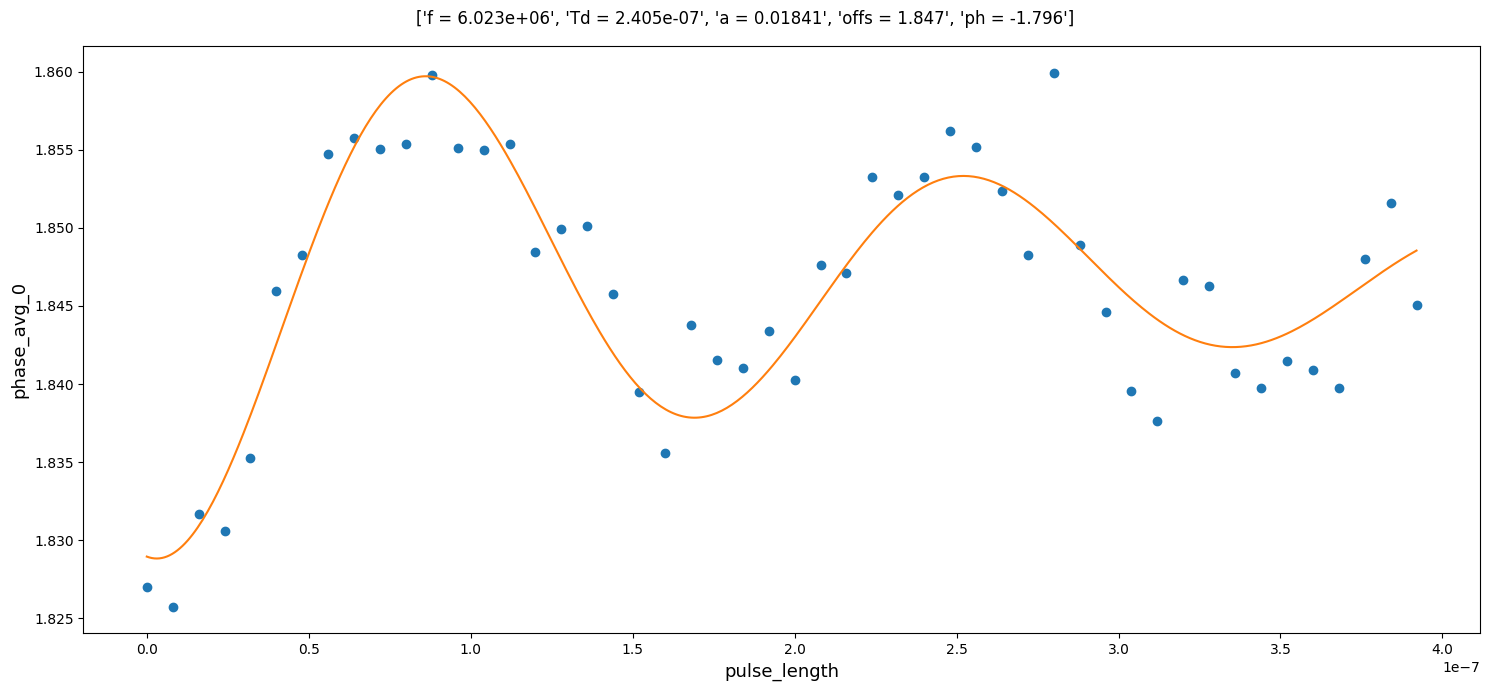

Cell 4: t_pi = 83.02 ns


Save pi pulse time in sample as pi? y/n y


Ok, saving in cell 4!


In [375]:
qf = qfit.QFIT()
qf.load(entries = ['pulse_length', f'phase_avg_0'])
qf.fit_damped_sine()
t_pi = 0.5/qf.popt[0]
print(f"Cell {cid}: t_pi = {t_pi * 1e9: .2f} ns")
if input("Save pi pulse time in sample as pi? y/n") == "y": 
    print(f"Ok, saving in cell {cid}!")
    sample[cid]["pi"] = t_pi

In [21]:
t_max = 2000e-9
t_step = 20e-9
averages = 1000
iterations = 100

In [22]:
with QiJob() as multi_rabi: 
    q = QiCells(len(sample))
    length = QiTimeVariable()
    with ForRange(length, 0, t_max, t_step): 
        for cell in q: 
            #Wait(cell, length)
            Play(cell, QiPulse(length, frequency = cell["manip_frequency"]))
            ql.jobs.Readout(cell, save_to = "result")
            ql.jobs.Thermalize(cell)

exp = multi_rabi.create_experiment(qic, sample, averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'pulse_length', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"MultiRabi"
m.comment = f"""Multi Cell Rabi Experiment -> pi pulse times
 * {iterations} iterations a {averages} averages
 * Frontend RF Manipulation Attenuation {frontend_box.get_attenuation_rf_manip()} dB
"""
print(m.dirname, "\n", m.comment)
fbp = {p: frontend_box.get(p) for p in frontend_box.get_parameter_names()}
m.comment +=  f"\n\n{sample}\n\nFrontend Box Params: \n{fbp}"

m.measure_1D_AWG(iterations = iterations)

MultiRabi 
 Multi Cell Rabi Experiment -> pi pulse times
 * 100 iterations a 1000 averages
 * Frontend RF Manipulation Attenuation 21.0 dB



HTML(value="<table style='width:100%'><tr><td> (0/100) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='MultiRabi', layout=Layout(width='95%'))

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

HTML(value="<table style='width:100%'><tr><td> (0/100) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'))

KeyboardInterrupt: 

Plots saved in /home/superuser/data/perl_4/Richard_2/QTPZSE_MultiRabi/images


Latest file: /home/superuser/data/perl_4/Richard/QT2FGI_MultiRabi/QT2FGI_MultiRabi.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_0']


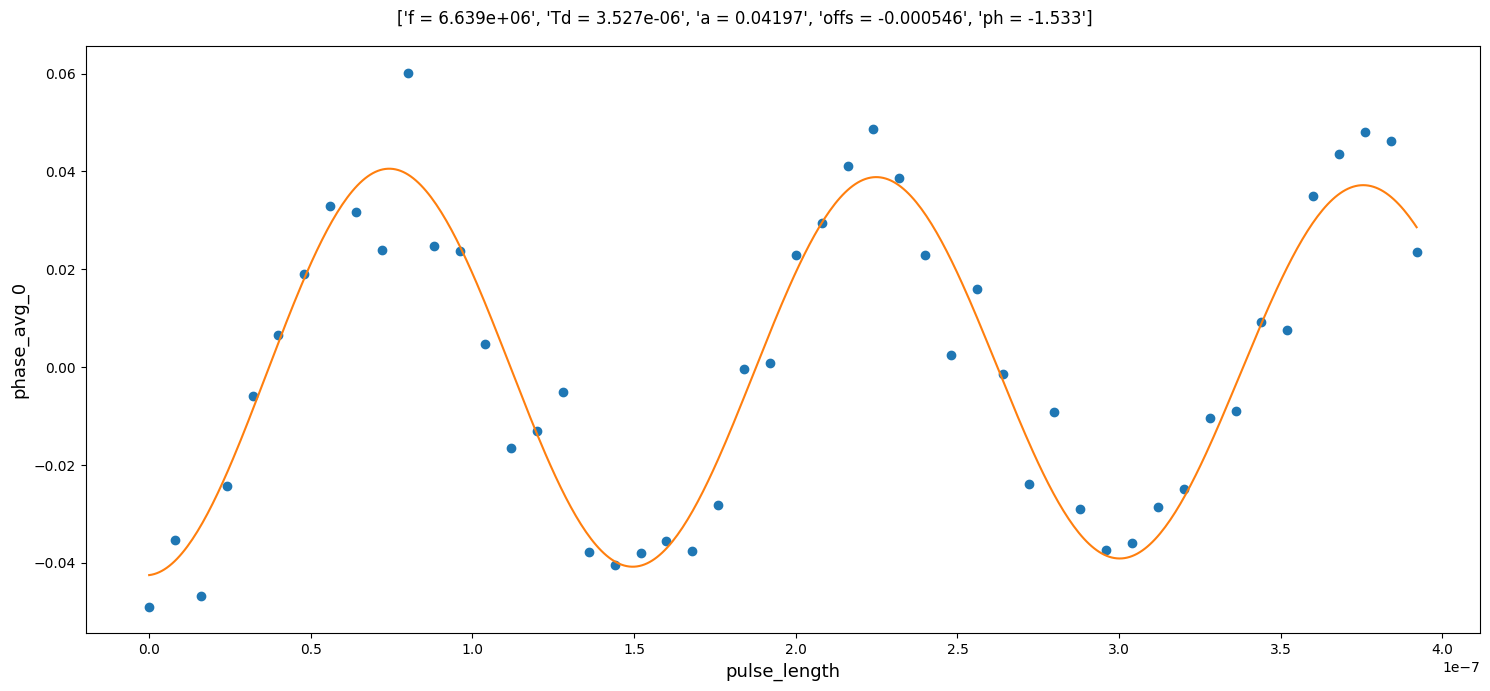

Cell 0: t_pi = 75.31 ns
Plots saved in /home/superuser/data/perl_4/Richard/QT2FGI_MultiRabi/images
Save pi pulse time in sample as pi? y/ny
Ok, saving in cell 0!
Latest file: /home/superuser/data/perl_4/Richard/QT2FGI_MultiRabi/QT2FGI_MultiRabi.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_1']


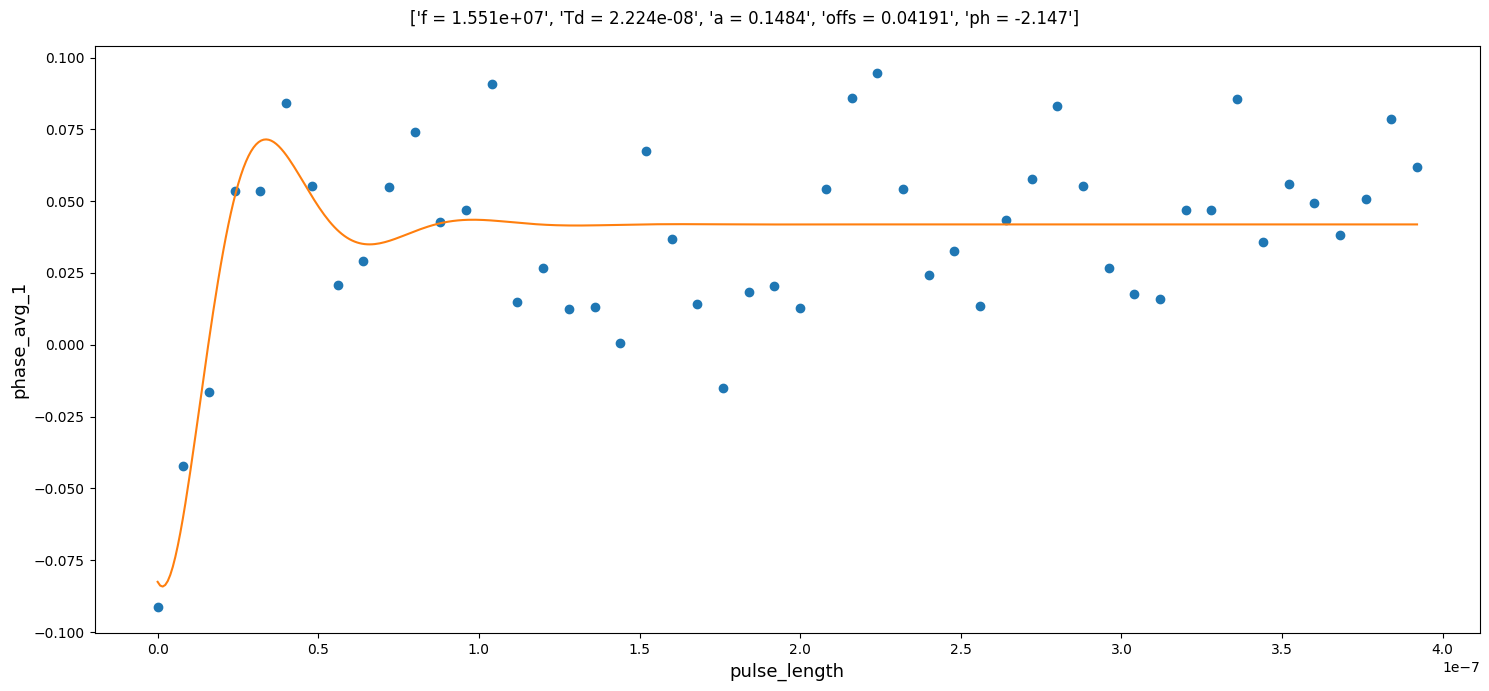

Cell 1: t_pi = 32.24 ns
Save pi pulse time in sample as pi? y/ny
Ok, saving in cell 1!
Latest file: /home/superuser/data/perl_4/Richard/QT2FGI_MultiRabi/QT2FGI_MultiRabi.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_2']


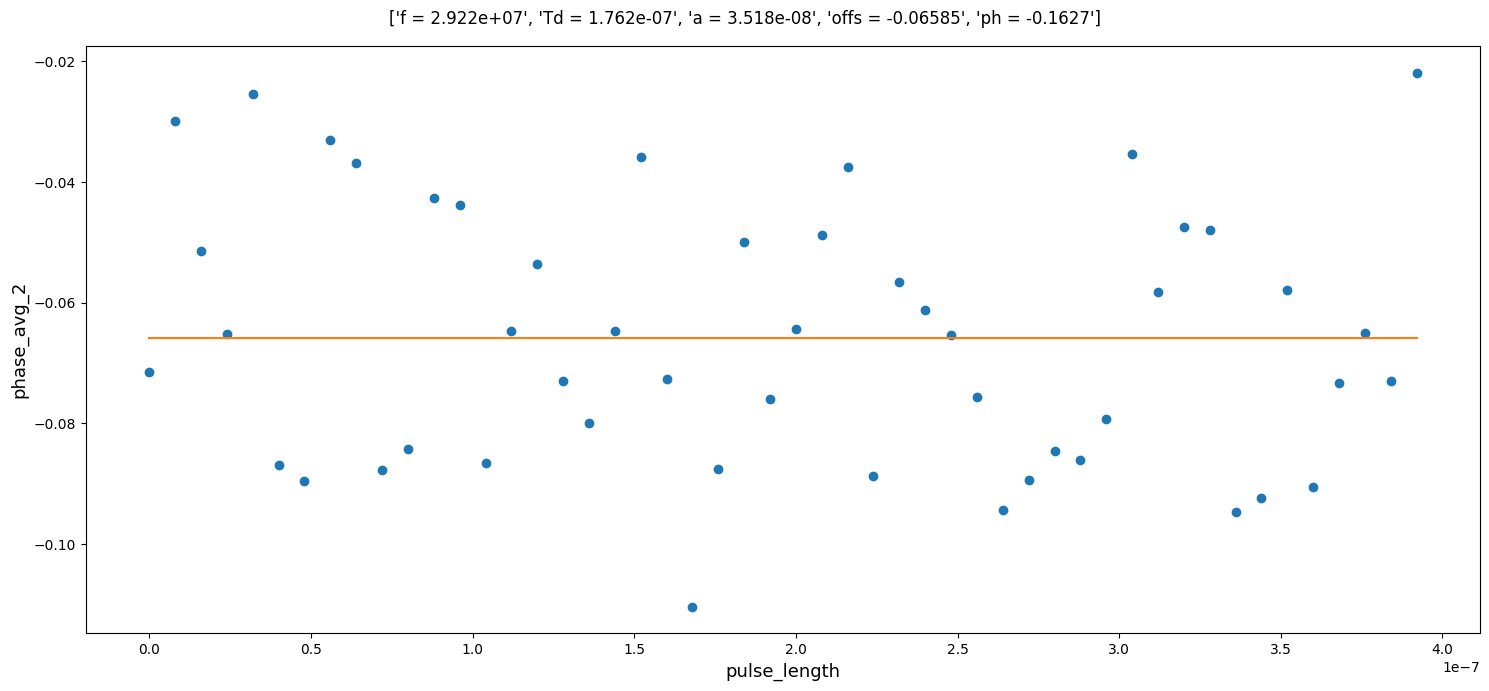

Cell 2: t_pi = 17.11 ns
Save pi pulse time in sample as pi? y/nn
Latest file: /home/superuser/data/perl_4/Richard/QT2FGI_MultiRabi/QT2FGI_MultiRabi.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_3']


/home/superuser/notebooks/qkit_py_env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


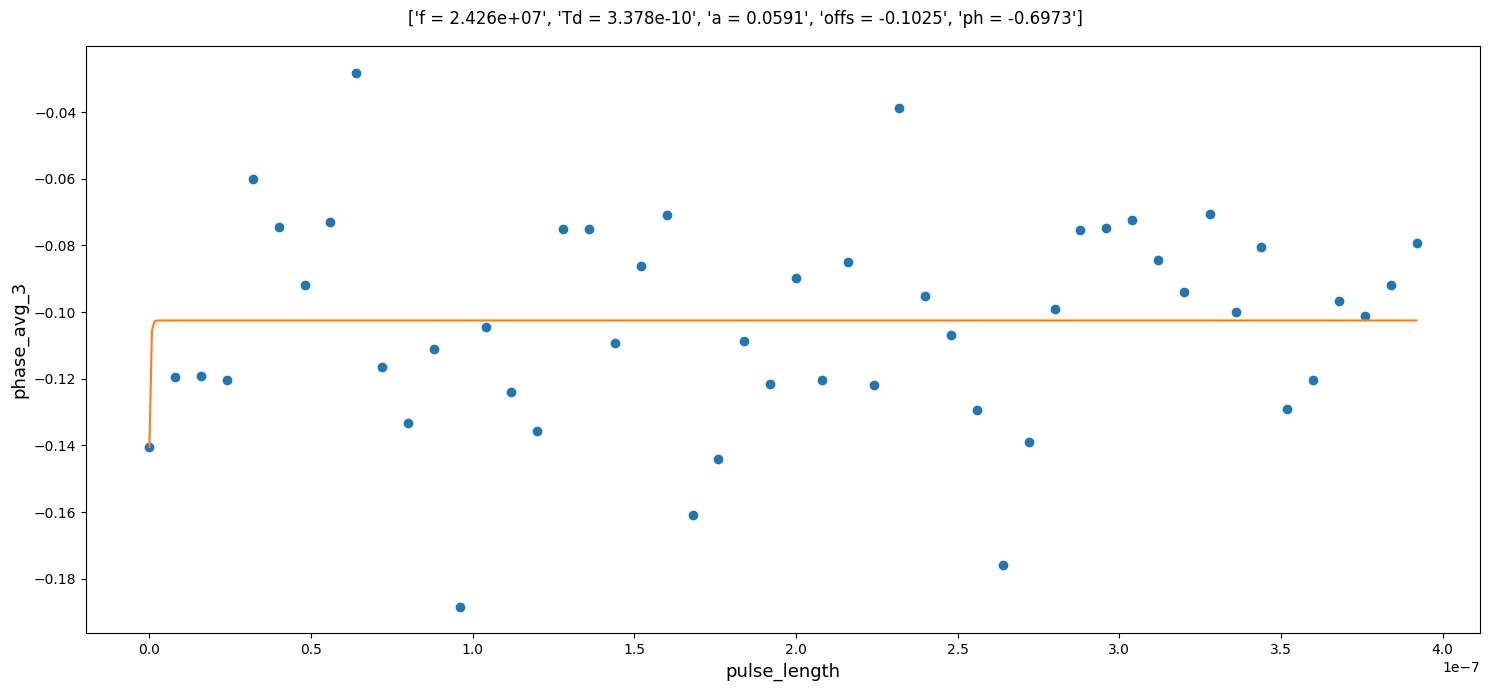

Cell 3: t_pi = 20.61 ns
Save pi pulse time in sample as pi? y/nn
Latest file: /home/superuser/data/perl_4/Richard/QT2FGI_MultiRabi/QT2FGI_MultiRabi.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'pulse_length', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/pulse_length', '/entry/data0/phase_avg_4']


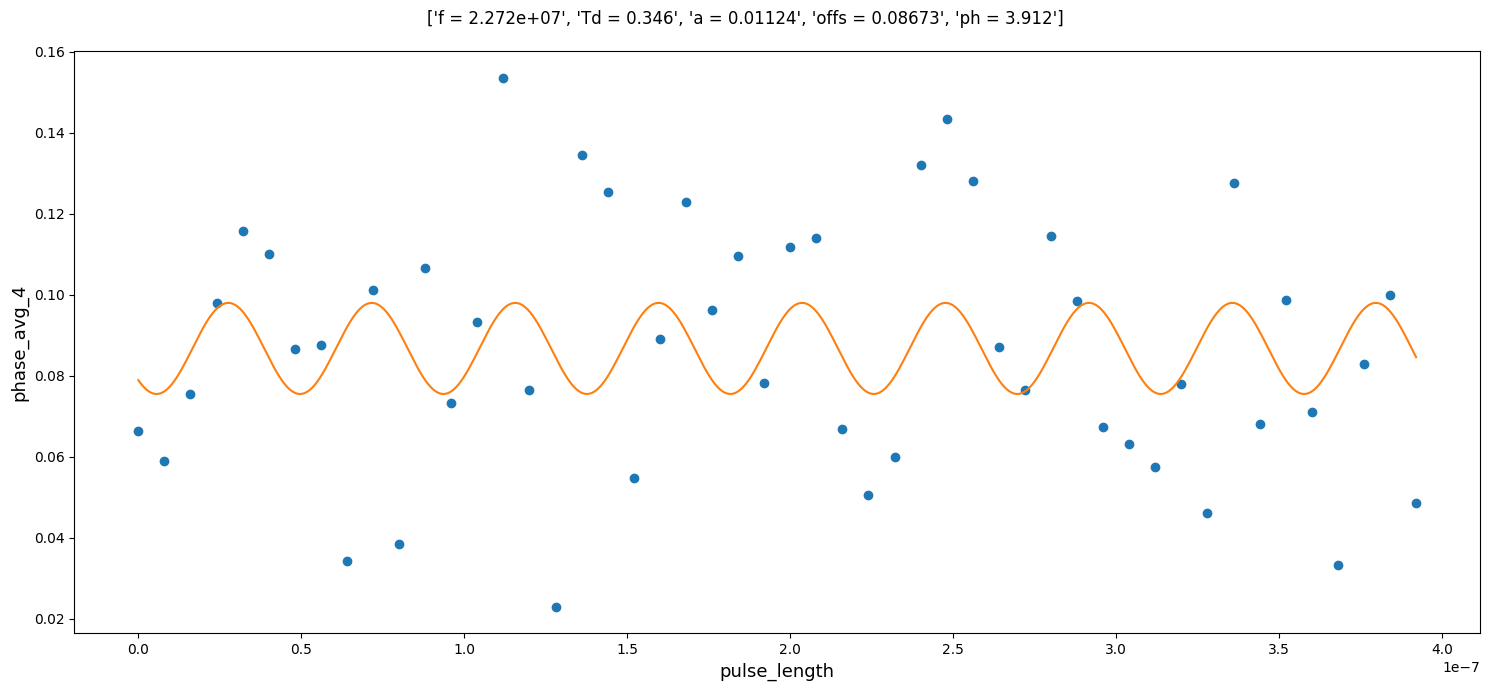

Cell 4: t_pi = 22.00 ns
Save pi pulse time in sample as pi? y/nn


In [20]:
qf = qfit.QFIT()
for cid, cell in enumerate(sample): 
    qf.load(file_name = "QT2C12", entries = ['pulse_length', f'phase_avg_{cid}'])
    qf.fit_damped_sine()
    t_pi = 0.5 / qf.popt[0]
    print(f"Cell {cid}: t_pi = {t_pi * 1e9: .2f} ns")
    if input("Save pi pulse time in sample as pi? y/n") == "y": 
        print(f"Ok, saving in cell {cid}!")
        cell["pi"] = t_pi

## Rabi with Detuning Sweep

In [434]:
t_max = 500e-9
t_step = 4e-9
averages = 2000 #5min

detuning_max = 100e6
detuning_step = 1e6

In [435]:
with QiJob() as multi_rabi: 
    q = QiCells(len(sample))
    results = [QiResult("result") for _ in q]
    length = QiTimeVariable()
    with ForRange(length, 0, t_max, t_step): 
        for cell, result in zip(q, results): 
            Play(cell, QiPulse(length, frequency = cell["manip_frequency"]))
            ql.jobs.Readout(cell, save_to = result)
            ql.jobs.Thermalize(cell)

exp = multi_rabi.create_experiment(qic, sample, averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'pulse_length', 
                   x_set_obj = None, 
                   x_unit = 's')

def set_detuning(detuning): 
    for cell in sample: 
        f_IF = cell["manip_frequency"] + detuning
        qic_cell = qic.cell[cell.qic_cell]
        qic_cell.manipulation.internal_frequency = f_IF
m.set_y_parameters(y_vec = np.arange(-detuning_max, detuning_max, detuning_step), 
                   y_coordname = 'detuning', 
                   y_set_obj = set_detuning, 
                   y_unit = 'Hz')

m.dirname = f"MultiRabiWithDetuning"
m.comment = f"""Multi Cell Rabi Experiment with detuning
 * {averages} averages
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_2D_AWG()

MultiRabiWithDetuning 
 Multi Cell Rabi Experiment with detuning
 * 2000 averages



HTML(value="<table style='width:100%'><tr><td> (0/200) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='MultiRabiWithDetuning', layout=Layout(width='95%'), max=200)

HTML(value="<table style='width:100%'><tr><td> (0/2000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=2000)

HTML(value="<table style='width:100%'><tr><td> (0/125) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=125)

Plots saved in /home/superuser/data/perl_4/Richard_2/QU0T2K_MultiRabiWithDetuning/images


In [262]:
manip_flo

4970000000.0

In [390]:
cid = 3
detuning = 4e6

cell = sample[cid]
f_IF = cell["manip_frequency"] + detuning
f_RF = manip_flo + f_IF
print(f"IF {cid}: {cell['manip_frequency'] * 1e-6: .3f} MHz -> {f_IF * 1e-6: .3f} MHz")
print(f"RF {cid}: {cell['f_01'] * 1e-9: .6f} GHz -> {f_RF * 1e-9: .6f} GHz")
if input("Proceed? (y/N) ") == "y": 
    print(f"Ok, saving in cell {cid}!")
    cell["manip_frequency"] = f_IF
    cell["f_01"] = f_RF

IF 3: -37.720 MHz -> -33.720 MHz
RF 3: 4.932280 GHz -> 4.936280 GHz
Proceed? (y/N) y
Ok, saving in cell 3!


## T1: Measure energy relaxation time $T_1$

In [378]:
t_max = 4e-6
t_step = 100e-9
averages = 10000
iterations = 10

In [379]:
with QiJob() as multi_t1: 
    q = QiCells(len(sample))
    results = [QiResult("result") for _ in q]
    length = QiTimeVariable()
    with ForRange(length, 0, t_max, t_step): 
        for cell, result in zip(q, results): 
            ql.jobs.PiPulse(cell)
            Wait(cell, length)
            ql.jobs.Readout(cell, save_to = result)
            ql.jobs.Thermalize(cell)

exp = multi_t1.create_experiment(qic, sample, averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'delay', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"MultiT1"
m.comment = f"""Multi Cell T1 Experiment -> energy relaxation times
 * {iterations} iterations a {averages} averages
"""
print(m.dirname, "\n", m.comment)
fbp = {p: frontend_box.get(p) for p in frontend_box.get_parameter_names()}
m.comment +=  f"\n\n{sample}\n\nFrontend Box Params: \n{fbp}"

m.measure_1D_AWG(iterations = iterations)

MultiT1 
 Multi Cell T1 Experiment -> energy relaxation times
 * 10 iterations a 10000 averages



HTML(value="<table style='width:100%'><tr><td> (0/10) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='MultiT1', layout=Layout(width='95%'), max=10)

HTML(value="<table style='width:100%'><tr><td> (0/10000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=10000)

HTML(value="<table style='width:100%'><tr><td> (0/40) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=40)

Plots saved in /home/superuser/data/perl_4/Richard_2/QTRL3M_MultiT1/images


Latest file: /home/superuser/data/perl_4/Richard/QT3QB2_MultiT1/QT3QB2_MultiT1.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_0']


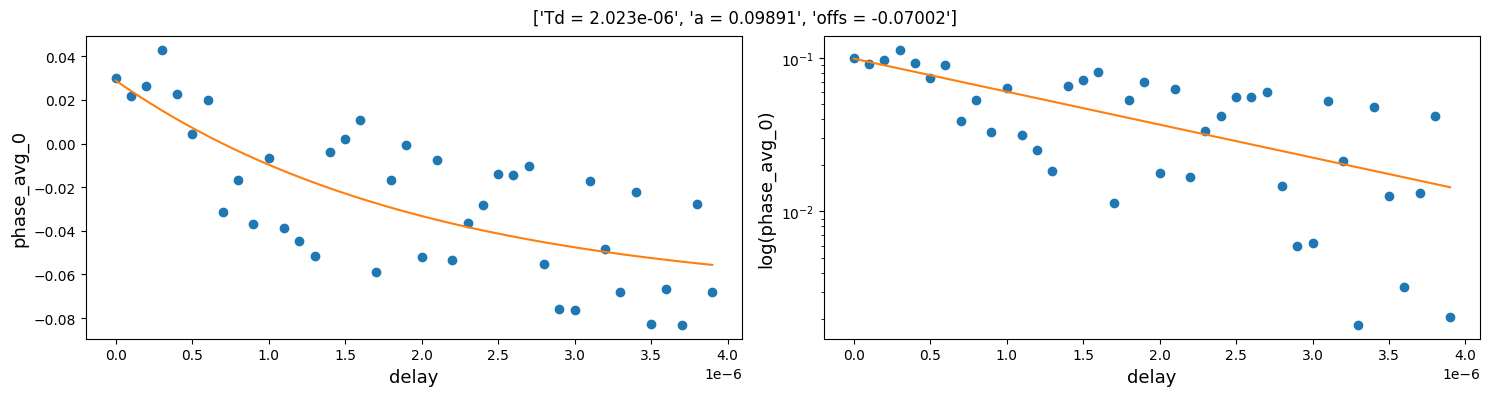

Cell 0: T1 = 2.023 µs (Old: 1.56 µs)
Save T1 time in sample? [y/N] 
Latest file: /home/superuser/data/perl_4/Richard/QT3QB2_MultiT1/QT3QB2_MultiT1.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_1']


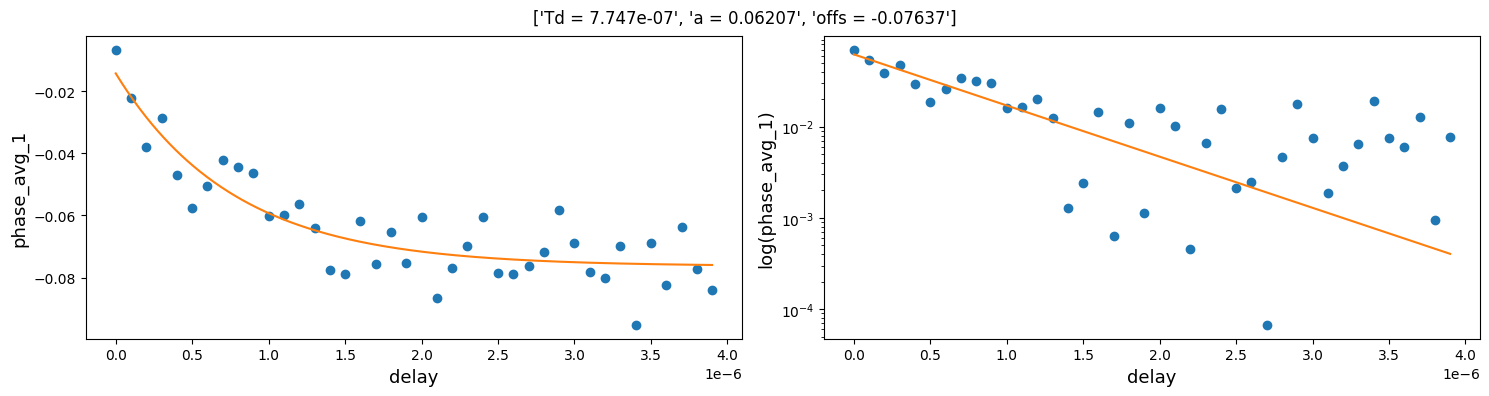

Cell 1: T1 = 0.775 µs (Old: 0.48 µs)
Save T1 time in sample? [y/N] 
Latest file: /home/superuser/data/perl_4/Richard/QT3QB2_MultiT1/QT3QB2_MultiT1.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_2']


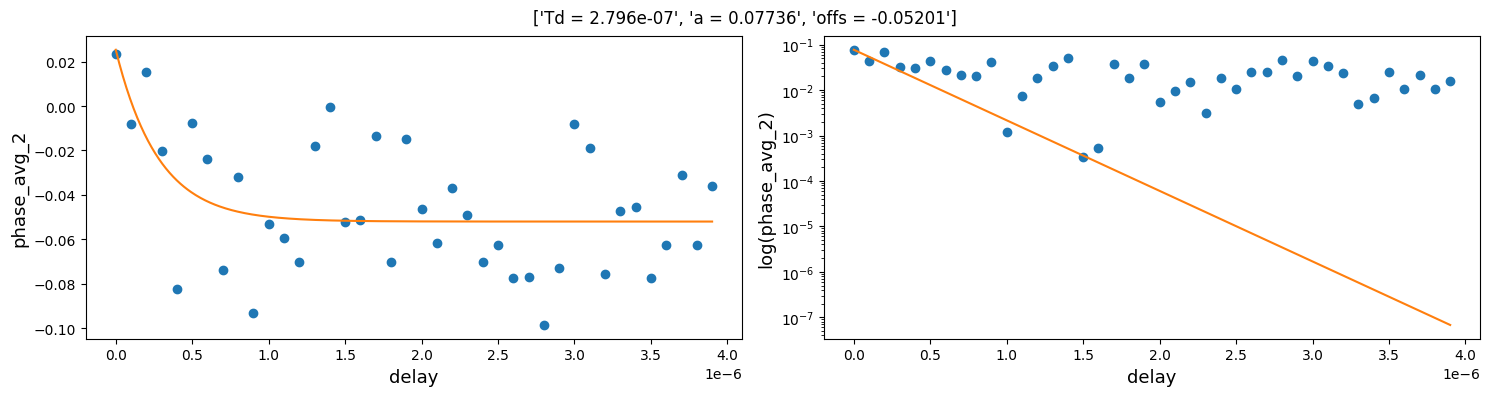

Cell 2: T1 = 0.280 µs (Old: 0.67 µs)
Save T1 time in sample? [y/N] 
Latest file: /home/superuser/data/perl_4/Richard/QT3QB2_MultiT1/QT3QB2_MultiT1.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_3']


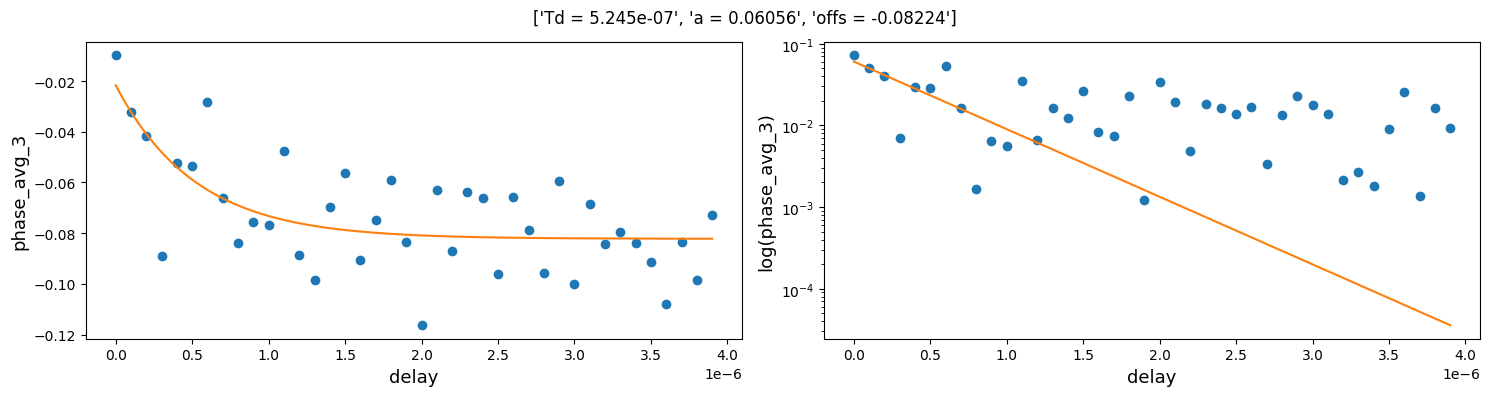

Cell 3: T1 = 0.525 µs (Old: 0.78 µs)
Save T1 time in sample? [y/N] 
Latest file: /home/superuser/data/perl_4/Richard/QT3QB2_MultiT1/QT3QB2_MultiT1.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_4']


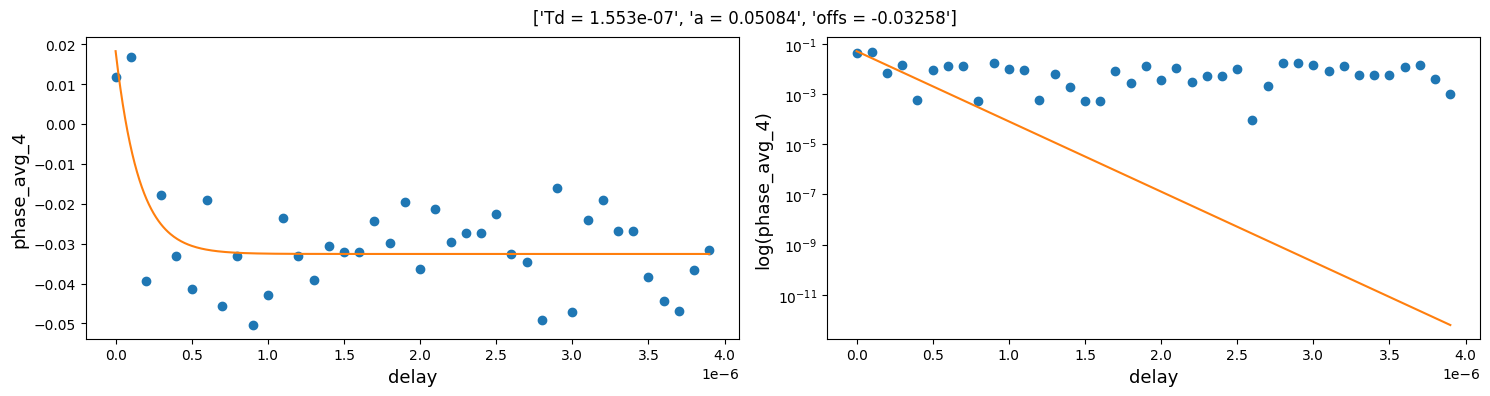

Cell 4: T1 = 0.155 µs (Old: 0.22 µs)
Save T1 time in sample? [y/N] 


In [145]:
qf = qfit.QFIT()
for cid, cell in enumerate(sample): 
    qf.load(entries = ['delay', f'phase_avg_{cid}'])
    qf.fit_exp()
    t1 = qf.popt[0]
    print(f"Cell {cid}: T1 = {t1 * 1e6: .3f} µs (Old: {cell['T1'] * 1e6: .2f} µs)")
    if input(f"Save T1 time in sample? [y/N] ") == "y": 
        print(f"Ok, saving in cell {cid}!")
        cell["T1"] = t1

## SpinEcho: Measure decoherence time $T_2^ * $

In [28]:
t_max = 8e-6
t_step = 200e-9
averages = 10000
iterations = 10

In [29]:
with QiJob() as multi_echo: 
    q = QiCells(2)#len(sample))
    results = [QiResult("result") for _ in q]
    length = QiTimeVariable()
    length_half = QiTimeVariable()
    with ForRange(length, 0, t_max, t_step): 
        Assign(length_half, length >> 1)  # divide by two (possible rounding error!)
        for cell, result in zip(q, results): 
            ql.jobs.PiHalfPulse(cell)
            Wait(cell, length_half)
            ql.jobs.PiPulse(cell, phase = np.pi / 2) # Pi(Y) Pulse
            Wait(cell, length_half)
            ql.jobs.PiHalfPulse(cell)
            ql.jobs.Readout(cell, save_to = result)
            ql.jobs.Thermalize(cell)

exp = multi_echo.create_experiment(qic, sample, averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'delay', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"MultiSpinEcho"
m.comment = f"""Multi Cell SpinEcho Experiment -> decoherence times
 * {iterations} iterations a {averages} averages
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D_AWG(iterations = iterations)

MultiSpinEcho 
 Multi Cell SpinEcho Experiment -> decoherence times
 * 10 iterations a 10000 averages



HTML(value="<table style='width:100%'><tr><td> (0/10) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='MultiSpinEcho', layout=Layout(width='95%'), max=10)

HTML(value="<table style='width:100%'><tr><td> (0/10000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=10000)

HTML(value="<table style='width:100%'><tr><td> (0/40) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=40)

Plots saved in /home/superuser/data/perl_4/Richard/QT2FPP_MultiSpinEcho/images
Latest file: /home/superuser/data/perl_4/Richard/QT2FPP_MultiSpinEcho/QT2FPP_MultiSpinEcho.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_avg_0', 'amplitude_avg_1', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_avg_0', 'phase_avg_1', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_0']


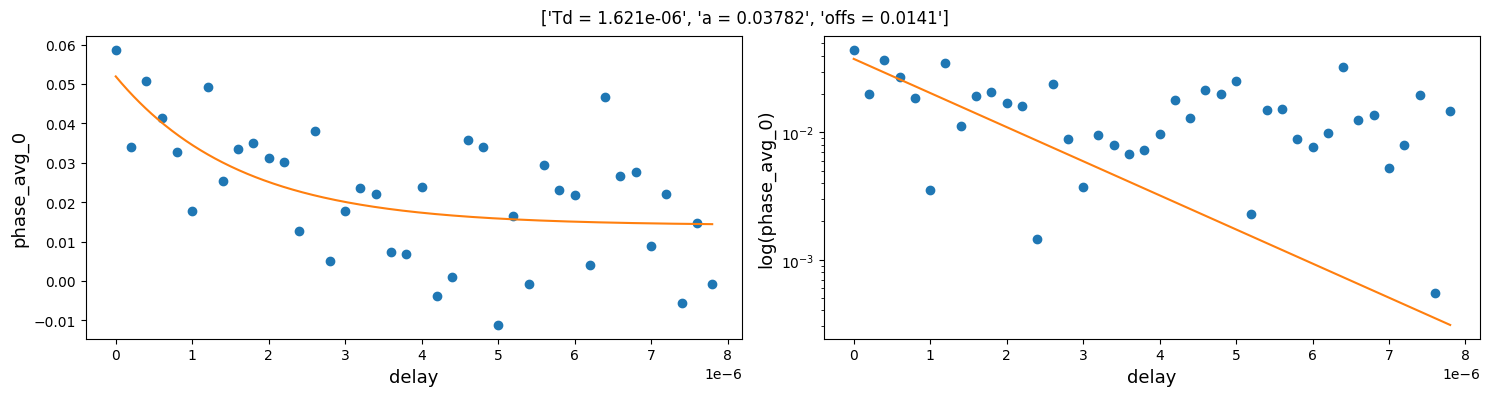

Cell 0: T2* = 1.621 µs
Save T2* time in sample? y/ny
Ok, saving in cell 0!
Latest file: /home/superuser/data/perl_4/Richard/QT2FPP_MultiSpinEcho/QT2FPP_MultiSpinEcho.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_avg_0', 'amplitude_avg_1', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_avg_0', 'phase_avg_1', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_1']


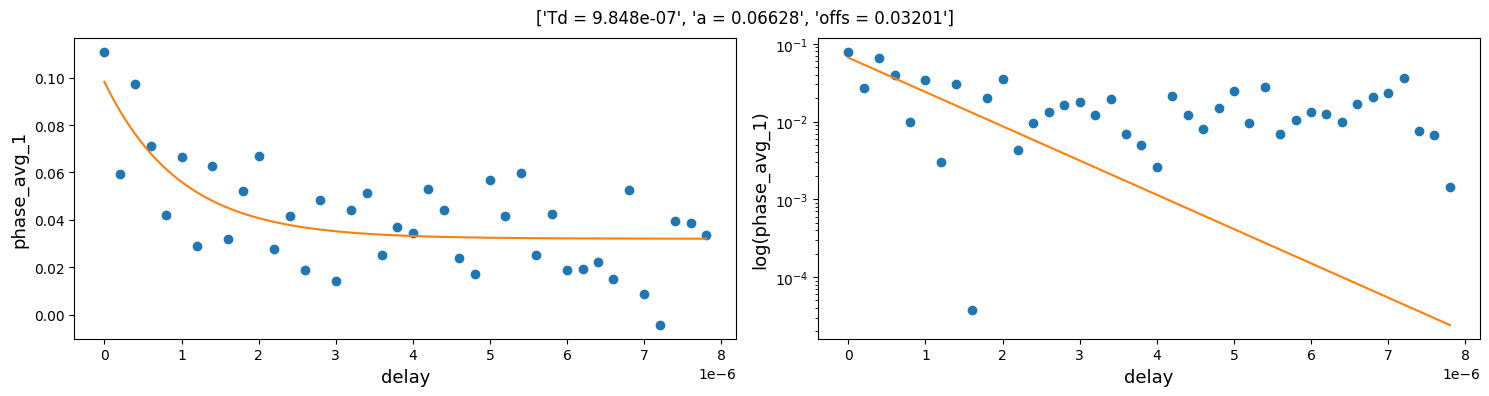

Cell 1: T2* = 0.985 µs
Save T2* time in sample? y/ny
Ok, saving in cell 1!


In [30]:
qf = qfit.QFIT()
for cid, cell in enumerate(sample): 
    if cid > 1: 
        continue
    qf.load(entries = ['delay', f'phase_avg_{cid}'])
    qf.fit_exp()
    t2star = qf.popt[0]
    print(f"Cell {cid}: T2 * = {t2star * 1e6: .3f} µs")
    if input(f"Save T2 * time in sample? y/n") == "y": 
        print(f"Ok, saving in cell {cid}!")
        cell["T2 * "] = t2star

## Ramsey: Measure decoherence time $T_2$

In [147]:
t_max = 1e-6
t_step = 20e-9
detuning = -4e6 # 1e6 = 1µs periodicity
averages = 10000
iterations = 10

In [148]:
with QiJob() as multi_ramsey: 
    q = QiCells(len(sample))
    results = [QiResult("result") for _ in q]
    length = QiTimeVariable()
    with ForRange(length, 0, t_max, t_step): 
        for cell, result in zip(q, results): 
            ql.jobs.PiHalfPulse(cell, detuning = detuning)
            Wait(cell, length)
            ql.jobs.PiHalfPulse(cell, detuning = detuning)
            ql.jobs.Readout(cell, save_to = result)
            ql.jobs.Thermalize(cell)

exp = multi_ramsey.create_experiment(qic, sample, averages = averages)
m = Measure_td(qic.sample, exp.readout)
m.set_x_parameters(x_vec = exp.time_range(0, t_max, t_step), 
                   x_coordname = 'delay', 
                   x_set_obj = None, 
                   x_unit = 's')

m.dirname = f"MultiRamsey"
m.comment = f"""Multi Cell Ramsey Experiment -> decoherence times
 * {iterations} iterations a {averages} averages
 * Detuning of f_01: {detuning} Hz
"""
print(m.dirname, "\n", m.comment)
m.comment +=  f"\n\n{sample}"

m.measure_1D_AWG(iterations = iterations)

MultiRamsey 
 Multi Cell Ramsey Experiment -> decoherence times
 * 10 iterations a 10000 averages
 * Detuning of f_01: -4000000.0 Hz



HTML(value="<table style='width:100%'><tr><td> (0/10) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='MultiRamsey', layout=Layout(width='95%'), max=10)

HTML(value="<table style='width:100%'><tr><td> (0/10000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:-- …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=10000)

HTML(value="<table style='width:100%'><tr><td> (0/50) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=50)

Plots saved in /home/superuser/data/perl_4/Richard/QT3QEY_MultiRamsey/images


Latest file: /home/superuser/data/perl_4/Richard/QT2G25_MultiRamsey/QT2G25_MultiRamsey.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_avg_0', 'amplitude_avg_1', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_avg_0', 'phase_avg_1', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_1']


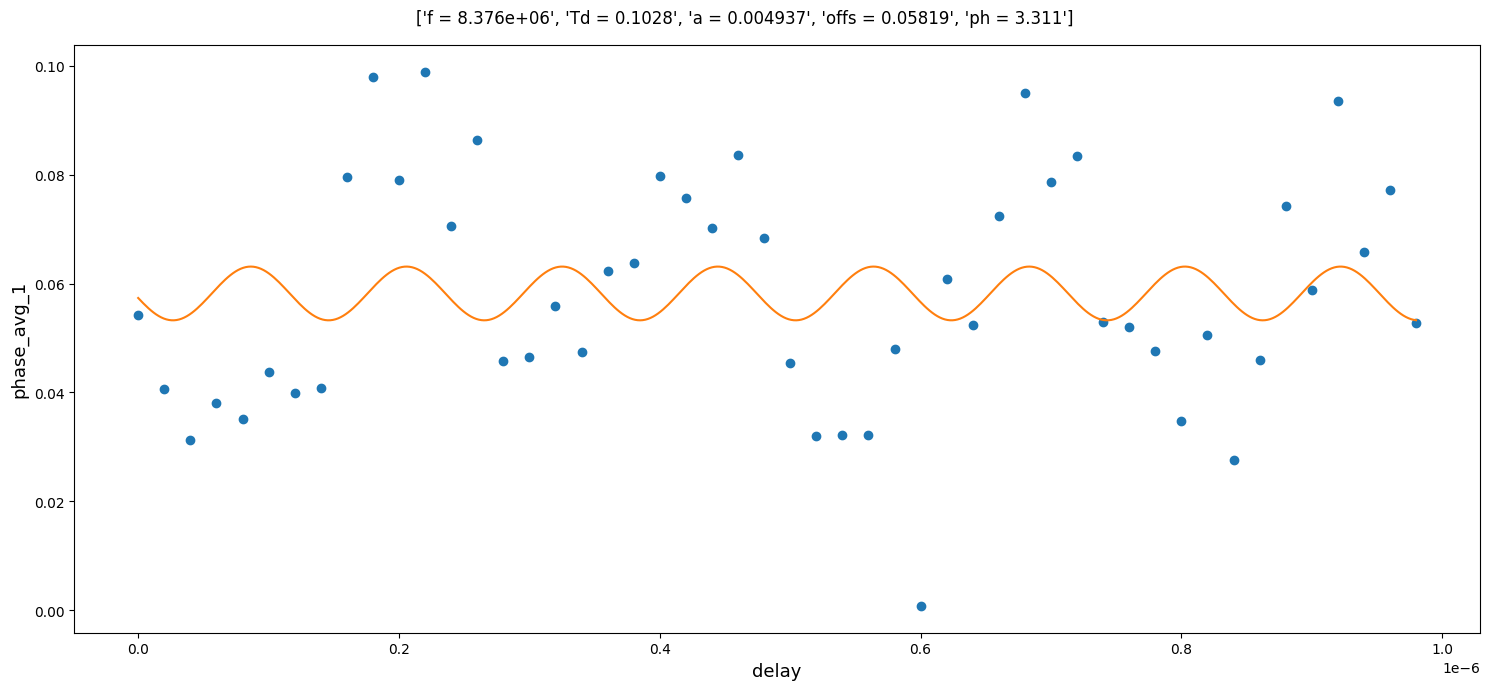

Cell 1: T2 = 102798.420 µs
Cell 1: f_01 = 5093.180 MHz (Old: 5088.804 MHz)
Save T2 time in sample? y/nn
Save f_01 and update manip_frequency in sample? y/nn


In [46]:
cid = 1
cell = sample[cid]
qf = qfit.QFIT()
qf.load(entries = ['delay', f'phase_avg_{cid}'])
qf.fit_damped_sine([1 / 120e-9, 1e-6, 0.06, 0.12, np.pi])
f01 = cell["f_01"] + detuning + qf.popt[0] * (1 if detuning < 0 else -1)
t2 = qf.popt[1]
print(f"Cell {cid}: T2 = {t2 * 1e6: .3f} µs")
print(f"Cell {cid}: f_01 = {f01 * 1e-6: .3f} MHz (Old: {cell['f_01'] * 1e-6: .3f} MHz)")
if input(f"Save T2 time in sample? y/n") == "y": 
    print(f"Ok, saving in cell {cid}!")
    cell["T2"] = t2
if input(f"Save f_01 and update manip_frequency in sample? y/n") == "y": 
    print(f"Ok, saving in cell {cid}!")
    cell["f_01"] = f01
    cell["manip_frequency"] = cell["f_01"] - manip_flo

Latest file: /home/superuser/data/perl_4/Richard/QT3QEY_MultiRamsey/QT3QEY_MultiRamsey.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_0']


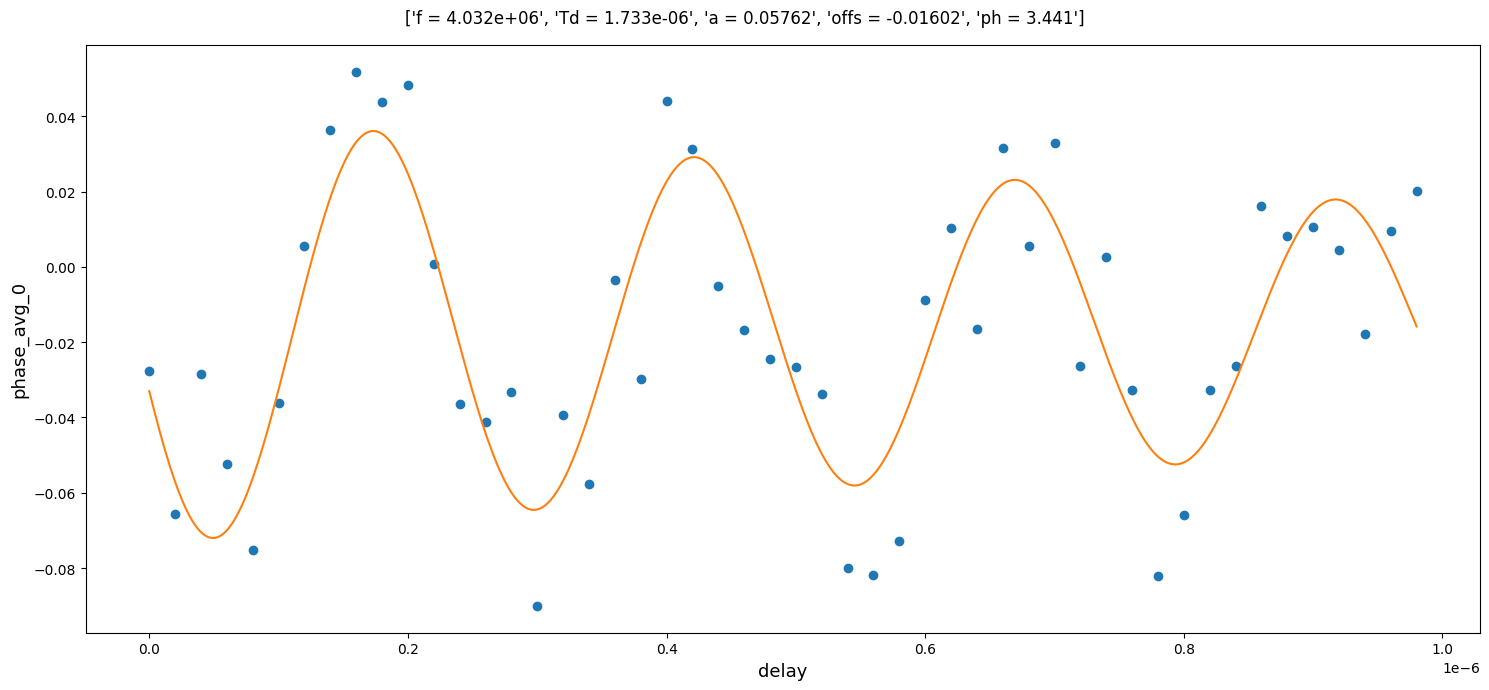

Cell 0: T2 = 1.733 µs
Save T2 time in sample? y/n
Cell 0: f_01 = 4814.507 MHz (Old: 4814.475 MHz)
Save f_01 and update manip_frequency in sample? y/n
Latest file: /home/superuser/data/perl_4/Richard/QT3QEY_MultiRamsey/QT3QEY_MultiRamsey.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_1']


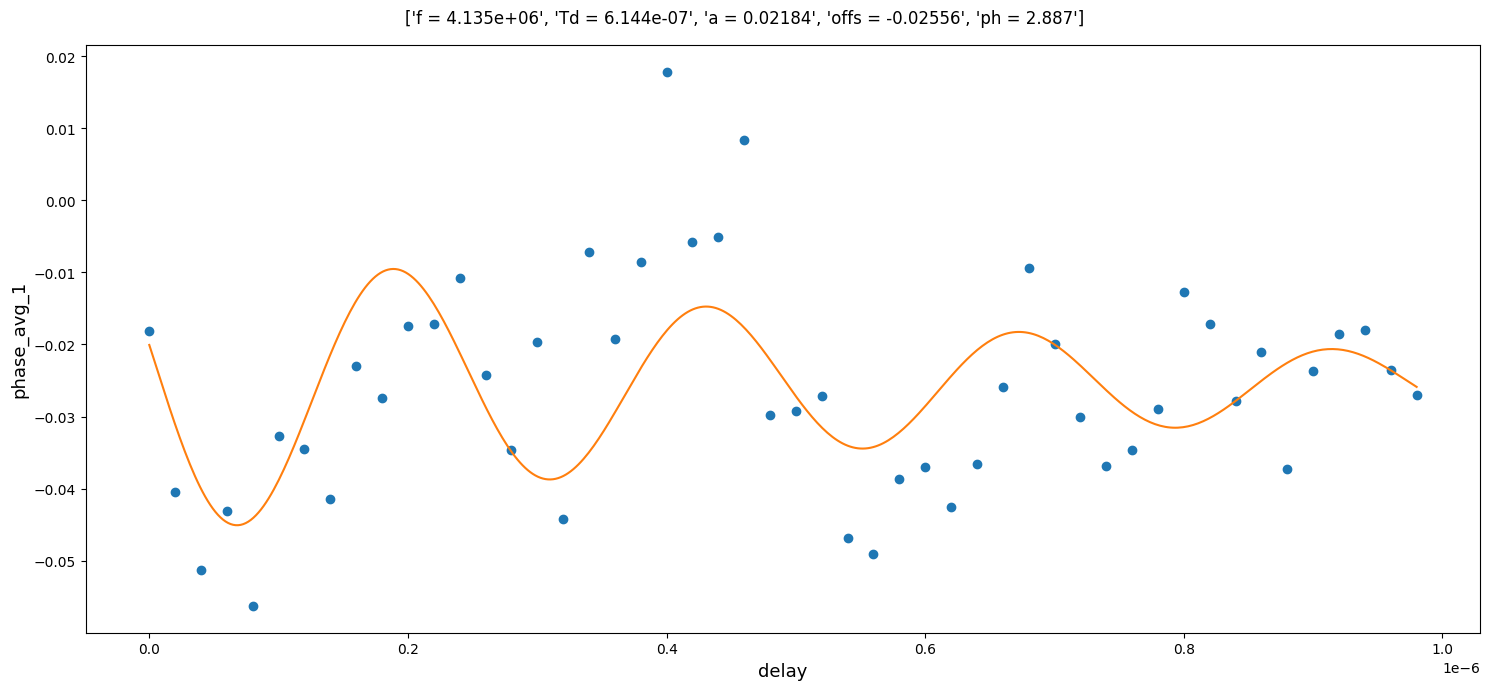

Cell 1: T2 = 0.614 µs
Save T2 time in sample? y/n
Cell 1: f_01 = 5088.988 MHz (Old: 5088.854 MHz)
Save f_01 and update manip_frequency in sample? y/n
Latest file: /home/superuser/data/perl_4/Richard/QT3QEY_MultiRamsey/QT3QEY_MultiRamsey.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_2']


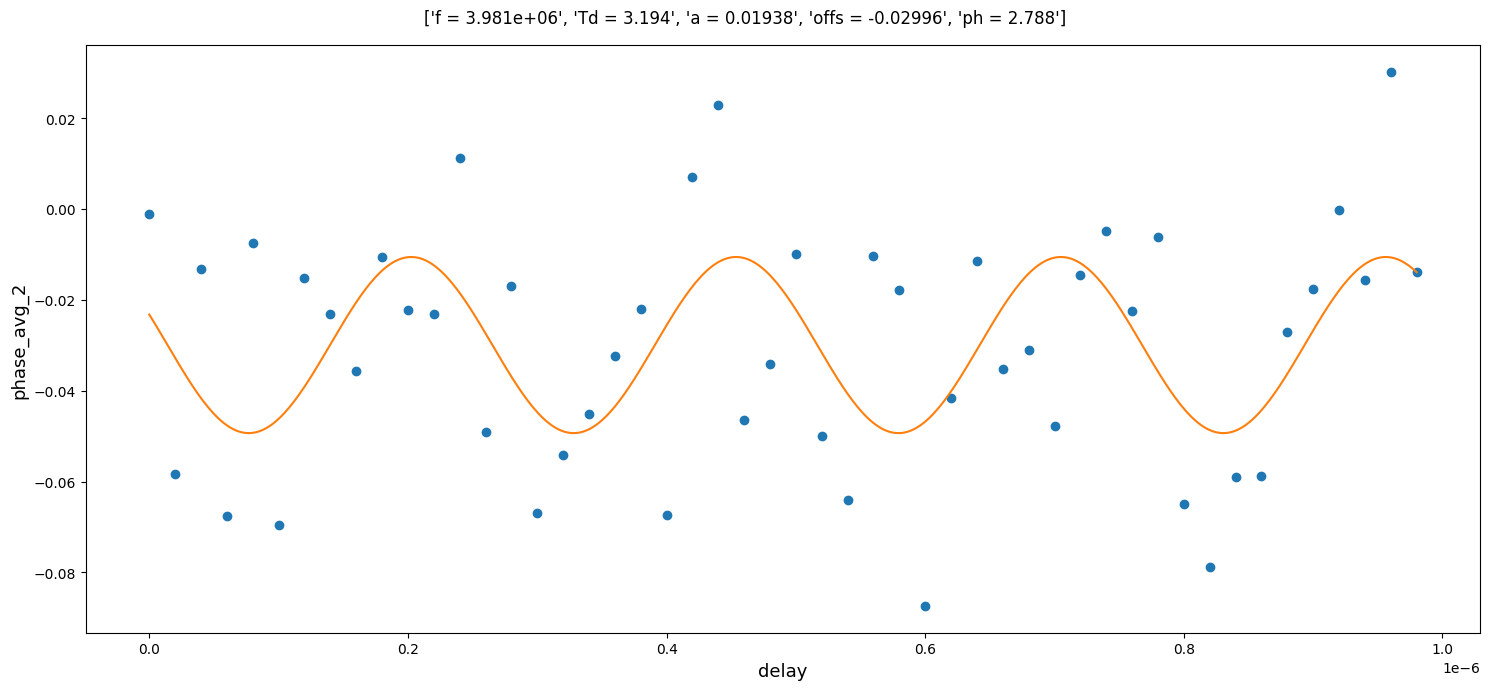

Cell 2: T2 = 3194306.642 µs
Save T2 time in sample? y/n
Cell 2: f_01 = 4712.775 MHz (Old: 4712.794 MHz)
Save f_01 and update manip_frequency in sample? y/n
Latest file: /home/superuser/data/perl_4/Richard/QT3QEY_MultiRamsey/QT3QEY_MultiRamsey.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_3']


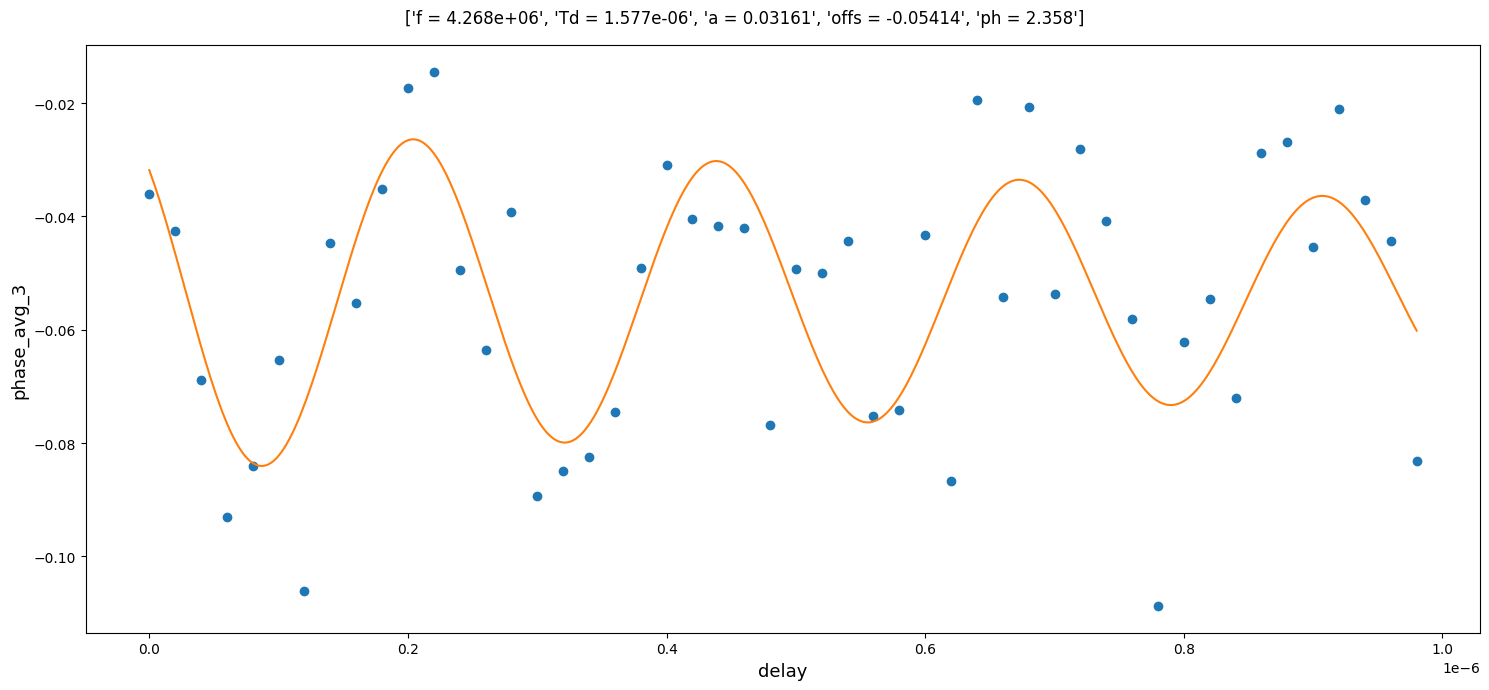

Cell 3: T2 = 1.577 µs
Save T2 time in sample? y/n
Cell 3: f_01 = 4934.585 MHz (Old: 4934.318 MHz)
Save f_01 and update manip_frequency in sample? y/n
Latest file: /home/superuser/data/perl_4/Richard/QT3QEY_MultiRamsey/QT3QEY_MultiRamsey.h5
Available data entries: <KeysViewHDF5 ['amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4', 'amplitude_avg_0', 'amplitude_avg_1', 'amplitude_avg_2', 'amplitude_avg_3', 'amplitude_avg_4', 'delay', 'iteration', 'measurement', 'phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_avg_0', 'phase_avg_1', 'phase_avg_2', 'phase_avg_3', 'phase_avg_4', 'readout_pulse_frequency', 'settings']>
Entries identified: ['/entry/data0/delay', '/entry/data0/phase_avg_4']


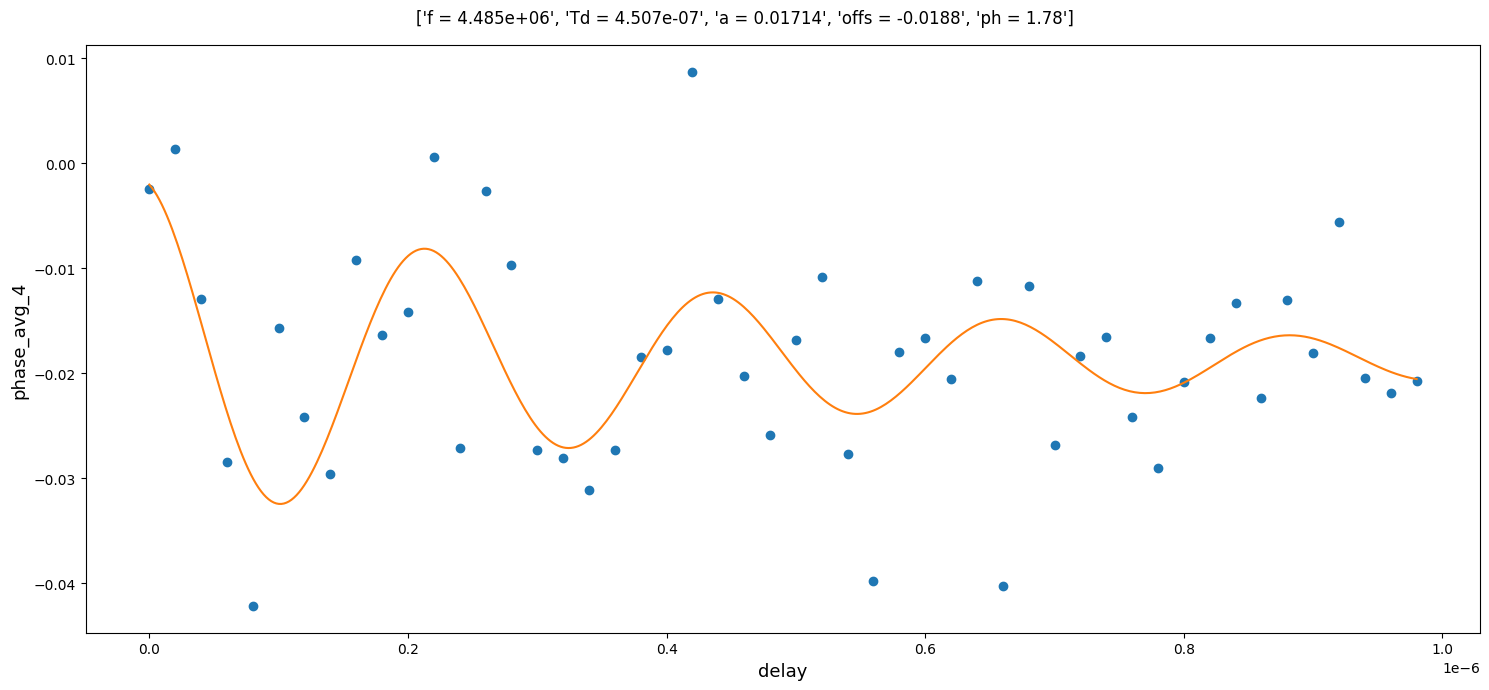

Cell 4: T2 = 0.451 µs
Save T2 time in sample? y/n
Cell 4: f_01 = 4903.218 MHz (Old: 4902.733 MHz)
Save f_01 and update manip_frequency in sample? y/n


In [149]:
qf = qfit.QFIT()
for cid, cell in enumerate(sample): 
    qf.load(entries = ['delay', f'phase_avg_{cid}'])
    qf.fit_damped_sine([abs(detuning), cell["T2 * "], 0.2, 0, np.pi])
    f01 = cell["f_01"] + detuning + qf.popt[0] * (1 if detuning < 0 else -1)
    t2 = qf.popt[1]
    print(f"Cell {cid}: T2 = {t2 * 1e6: .3f} µs")
    if input(f"Save T2 time in sample? y/n") == "y": 
        print(f"Ok, saving in cell {cid}!")
        cell["T2"] = t2
    print(f"Cell {cid}: f_01 = {f01 * 1e-6: .3f} MHz (Old: {cell['f_01'] * 1e-6: .3f} MHz)")
    if input(f"Save f_01 and update manip_frequency in sample? y/n") == "y": 
        print(f"Ok, saving in cell {cid}!")
        cell["f_01"] = f01
        cell["manip_frequency"] = cell["f_01"] - manip_flo

## Interleaved: Measure T1, T2, T2 * , and detuning simultaneously

In [18]:
import qiclib.experiment.qicode.qubit_times as iqqt_inner
import qiclib.experiment.qicode.qubit_times_qkit as iqqt

In [60]:
from importlib import reload

In [84]:
reload(iqqt_inner)
reload(iqqt)

<module 'qiclib.experiment.qicode.qubit_times_qkit' from '/home/superuser/qup_client/qiclib/experiment/qicode/qubit_times_qkit.py'>

In [308]:
delays_t1 = np.arange(0, 5e-6, 100e-9)
delays_ramsey = np.arange(0, 1e-6, 20e-9)
delays_echo = np.arange(0, 5e-6, 100e-9)
detuning = -5e6
averages = 1000
iterations = 100000
print(len(delays_t1) + len(delays_ramsey) + len(delays_echo))

152


In [20]:
import qiclib.packages.utility as util

In [51]:
delays_t1 = np.array([util.conv_time_to_cycle_time(t, "round") for t in 8 * np.logspace(-9, -5.6, 22)])
delays_ramsey = np.arange(0, 3e-6, 40e-9)
delays_echo = delays_t1
detuning = -5e6
averages = 10000
iterations = 100000
print(len(delays_t1) + len(delays_ramsey) + len(delays_echo))

119


In [52]:
exp = iqqt.QubitTimesQkit(
    qic, sample, 
    delays_t1, delays_ramsey, delays_echo, 
    averages = averages, ramsey_detuning = detuning, 
    iterations = iterations)

exp.comment = f"""Multi Cell QubitTimesQkit Experiment
 * {iterations} iterations a {averages} averages
 * Detuning of f_01: {detuning} Hz
"""
print(exp.dirname, "\n", exp.comment)
m.comment +=  f"\n\n{sample}"

exp.configure()

qubit-times-iterations 
 Multi Cell QubitTimesQkit Experiment
 * 100000 iterations a 10000 averages
 * Detuning of f_01: -5000000.0 Hz



In [53]:
exp.record()

HTML(value="<table style='width:100%'><tr><td> (0/100000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--…

IntProgress(value=0, description='Iteration', layout=Layout(width='95%'), max=100000)

HTML(value="<table style='width:100%'><tr><td> (0/119) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=119)

/home/superuser/notebooks/qkit_py_env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/superuser/qkit/qkit/analysis/qfit.py:891: RuntimeWarning: invalid value encountered in sqrt
  self.std = np.sqrt(np.diag(self.pcov))
2021-06-01 15:21:32 [WARNING ]: Fit not successful. (qfit.py:837)
2021-06-01 15:26:07 [WARNING ]: Fit not successful. (qfit.py:837)
2021-06-01 15:28:24 [WARNING ]: Fit not successful. (qfit.py:837)
/home/superuser/qkit/qkit/analysis/qfit.py:149: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-t/Td)+offs
/home/superuser/qkit/qkit/analysis/qfit.py:659: RuntimeWarning: divide by zero encountered in double_scalars
  s_Td = -t_end/(np.log((np.abs(a_end-np.abs(s_offs)))/s_a))
2021-06-01 15:36:05 [WARNING ]: Fit not successful. (qfit.py:837)
2021-06-01 15:46:53 [WARNING ]: Fit not successful. (qfit.py:837)
20

KeyboardInterrupt: 